# Trump Speech Analysis for 2025 SOTU Predictions

This notebook analyzes the frequency of specific phrases to predict their occurrence in the 2025 SOTU address using:
1. Regular speeches (pre-inauguration)
2. Post-inauguration speeches (Jan 20, 2025 onwards)
3. Previous State of the Union addresses

## Setup

In [21]:
import os
import re
from datetime import datetime
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for plots
plt.style.use('default')
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = [12, 6]

# Set pandas display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [22]:
INAUGURATION_DATE = datetime(2025, 1, 20)
CONTEXT_WINDOW = 200 # words to display for context

Phrases to Track

Crime
Border
Justice
Law and order
Weapon / Weaponization
Kash / Patel
Police
Hunter / Biden
Judge
Death penalty
National Security
Sanctuary
Pardon
Golden Age
Lawfare
Bill / Barr
Clean house
Antifa / Anti-fa / Anti-fascist
Insurrection
Civil rights
FISA court
Prison reform
Martial law
Jeff / Sessions

In [ ]:
SEARCH_PHRASES = {
    # Energy
    "Energy": r'\benergy(?:s|\'s?)?(?:-\w+)?\b',
    
    # Artificial Intelligence / AI
    "Artificial Intelligence": r'\b(?:artificial\s+intelligence|ai)(?:s|\'s?)?(?:-\w+)?\b',
    
    # Big Beautiful Bill
    "Big Beautiful Bill": r'\bbig\s+beautiful\s+bill(?:s|\'s?)?(?:-\w+)?\b',
    
    # Biden
    "Biden": r'\bbiden(?:s|\'s?)?(?:-\w+)?\b',
    
    # Steel
    "Steel": r'\bsteel(?:s|\'s?)?(?:-\w+)?\b',
    
    # Investment
    "Investment": r'\binvestment(?:s|\'s?)?(?:-\w+)?\b',
    
    # Manufacturing
    "Manufacturing": r'\bmanufacturing(?:s|\'s?)?(?:-\w+)?\b',
    
    # Tariff
    "Tariff": r'\btariff(?:s|\'s?)?(?:-\w+)?\b',
    
    # Gas
    "Gas": r'\bgas(?:s|\'s?)?(?:-\w+)?\b',
    
    # Oil
    "Oil": r'\boil(?:s|\'s?)?(?:-\w+)?\b',
    
    # Chip
    "Chip": r'\bchip(?:s|\'s?)?(?:-\w+)?\b',
    
    # Elon / Musk
    "Elon Musk": r'\b(?:elon|musk)(?:s|\'s?)?(?:-\w+)?\b',
    
    # Golden
    "Golden": r'\bgolden(?:s|\'s?)?(?:-\w+)?\b',
    
    # Infrastructure
    "Infrastructure": r'\binfrastructure(?:s|\'s?)?(?:-\w+)?\b',
    
    # Nuclear
    "Nuclear": r'\bnuclear(?:s|\'s?)?(?:-\w+)?\b',
    
    # NVIDIA
    "NVIDIA": r'\bnvidia(?:s|\'s?)?(?:-\w+)?\b',
    
    # Microsoft
    "Microsoft": r'\bmicrosoft(?:s|\'s?)?(?:-\w+)?\b',
    
    # Meta
    "Meta": r'\bmeta(?:s|\'s?)?(?:-\w+)?\b',
    
    # Fake News
    "Fake News": r'\bfake\s+news(?:s|\'s?)?(?:-\w+)?\b',
    
    # Autopen
    "Autopen": r'\bautopen(?:s|\'s?)?(?:-\w+)?\b',
    
    # China
    "China": r'\bchina(?:s|\'s?)?(?:-\w+)?\b',
    
    # OpenAI
    "OpenAI": r'\bopenai(?:s|\'s?)?(?:-\w+)?\b',
    
    # Tesla
    "Tesla": r'\btesla(?:s|\'s?)?(?:-\w+)?\b',
    
    # Spacex
    "Spacex": r'\bspacex(?:s|\'s?)?(?:-\w+)?\b',
    
    # Starlink
    "Starlink": r'\bstarlink(?:s|\'s?)?(?:-\w+)?\b',
}

In [24]:
def count_phrases(text, phrases=SEARCH_PHRASES):
    """Count occurrences of phrases in text"""
    counts = {}
    for name, pattern in phrases.items():
        counts[name] = len(re.findall(pattern, text.lower()))
    return counts

def get_date_from_filename(filename):
    """Extract date from filename format YYYY-MM-DD_..."""
    date_str = filename.split('_')[0]
    return datetime.strptime(date_str, '%Y-%m-%d')

def read_transcript(filepath):
    """Read and return transcript text"""
    with open(filepath, 'r', encoding='utf-8') as f:
        return f.read()

def find_phrase_context(text, pattern, window=CONTEXT_WINDOW):
    """Find phrase in text with surrounding context"""
    matches = []
    for match in re.finditer(pattern, text.lower()):
        start = max(0, match.start() - window)
        end = min(len(text), match.end() + window)
        context = text[start:end]
        # Add ellipsis if we're not at the start/end of the text
        if start > 0:
            context = '...' + context
        if end < len(text):
            context = context + '...'
        matches.append(context)
    return matches

def process_directory(directory):
    """Process transcripts from speech and sotu directories only"""
    results = []
    categories_found = set()
    
    for root, _, files in os.walk(directory):
        category = os.path.basename(root)
        categories_found.add(category)
        for file in files:
            if file.endswith('.txt'):
                filepath = os.path.join(root, file)
                try:
                    date = get_date_from_filename(file)
                    text = read_transcript(filepath)
                    counts = count_phrases(text)
                    
                    results.append({
                        'date': date,
                        'file': file,
                        'category': category,
                        'text_length': len(text.split()),
                        'text': text,  # Store full text for context analysis
                        **counts
                    })
                except Exception as e:
                    print(f"Error processing {filepath}: {str(e)}")
    
    print("Categories found in directory:")
    for cat in sorted(categories_found):
        print(f"- {cat}")
    print("\nOnly 'speech' and 'sotu' categories will be analyzed.\n")
    
    return pd.DataFrame(results)


In [25]:

df = process_directory('.../data/processed-transcripts')
df

Categories found in directory:

Only 'speech' and 'sotu' categories will be analyzed.



""


In [26]:
# Process transcripts
df = process_directory('../data/processed-transcripts')
df = df.sort_values('date')

# Filter out press briefings
df = df[df['category'] != 'press briefing']

# Split data by date and category
speech_mask = df['category'] == 'speech'
sotu_mask = df['category'] == 'sotu'
date_mask = df['date'] >= INAUGURATION_DATE

# Create speech dataframes
df_speech = df[speech_mask]
df_speech_pre = df[speech_mask & ~date_mask]
df_speech_post = df[speech_mask & date_mask]

# Create non-speech and SOTU dataframes 
df_nonspeech = df[~speech_mask & ~sotu_mask]
df_nonspeech_pre = df[~speech_mask & ~sotu_mask & ~date_mask]
df_nonspeech_post = df[~speech_mask & ~sotu_mask & date_mask]
df_sotu = df[sotu_mask]

df_pre = pd.concat([df_speech_pre, df_nonspeech_pre])
df_post = pd.concat([df_speech_post, df_nonspeech_post])

# Print dataset statistics
print("Dataset Statistics:")
print("Speeches:")
print(f"Pre-inauguration: {len(df_speech_pre)}")
print(f"Post-inauguration: {len(df_speech_post)}")
print("\nNon-speeches:")
print(f"Pre-inauguration: {len(df_nonspeech_pre)}")
print(f"Post-inauguration: {len(df_nonspeech_post)}")
print("\nState of the Union:")
print(f"Total: {len(df_sotu)}")

print("\nWord Count Statistics:")
print("Speeches:")
print(f"Pre-inauguration average length: {df_speech_pre['text_length'].mean():.0f} words")
print(f"Post-inauguration average length: {df_speech_post['text_length'].mean():.0f} words")
print("\nNon-speeches:")
print(f"Pre-inauguration average length: {df_nonspeech_pre['text_length'].mean():.0f} words") 
print(f"Post-inauguration average length: {df_nonspeech_post['text_length'].mean():.0f} words")
print("\nState of the Union:")
print(f"Average length: {df_sotu['text_length'].mean():.0f} words")

print("\nDate Ranges:")
print("Speeches:")
print(f"Pre-inauguration: {df_speech_pre['date'].min().strftime('%Y-%m-%d')} to {df_speech_pre['date'].max().strftime('%Y-%m-%d')}")
print(f"Post-inauguration: {df_speech_post['date'].min().strftime('%Y-%m-%d')} to {df_speech_post['date'].max().strftime('%Y-%m-%d')}")
print("\nNon-speeches:")
print(f"Pre-inauguration: {df_nonspeech_pre['date'].min().strftime('%Y-%m-%d')} to {df_nonspeech_pre['date'].max().strftime('%Y-%m-%d')}")
print(f"Post-inauguration: {df_nonspeech_post['date'].min().strftime('%Y-%m-%d')} to {df_nonspeech_post['date'].max().strftime('%Y-%m-%d')}")


Categories found in directory:
- donald trump vlog
- interview
- press briefing
- press conference
- press gaggle
- processed-transcripts
- remarks
- sotu
- speech
- uncategorized

Only 'speech' and 'sotu' categories will be analyzed.

Dataset Statistics:
Speeches:
Pre-inauguration: 150
Post-inauguration: 26

Non-speeches:
Pre-inauguration: 122
Post-inauguration: 237

State of the Union:
Total: 4

Word Count Statistics:
Speeches:
Pre-inauguration average length: 11961 words
Post-inauguration average length: 8477 words

Non-speeches:
Pre-inauguration average length: 2158 words
Post-inauguration average length: 2734 words

State of the Union:
Average length: 5428 words

Date Ranges:
Speeches:
Pre-inauguration: 2023-09-29 to 2025-01-19
Post-inauguration: 2025-01-20 to 2025-06-26

Non-speeches:
Pre-inauguration: 2023-10-24 to 2025-01-19
Post-inauguration: 2025-01-20 to 2025-07-01


## Phrase Frequency Over Time

Speeches dropped off dramatically between election day and inauguration day. Non-speech transcripts mostly don't go back as far in time (need to scrape more data)

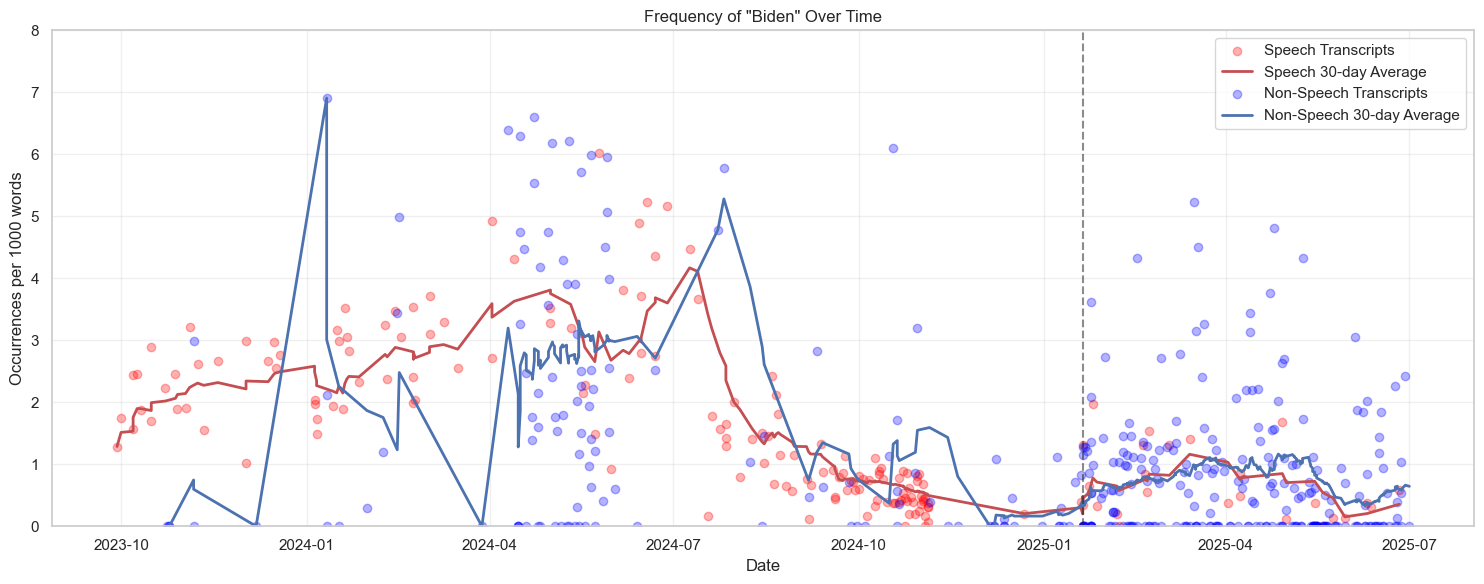

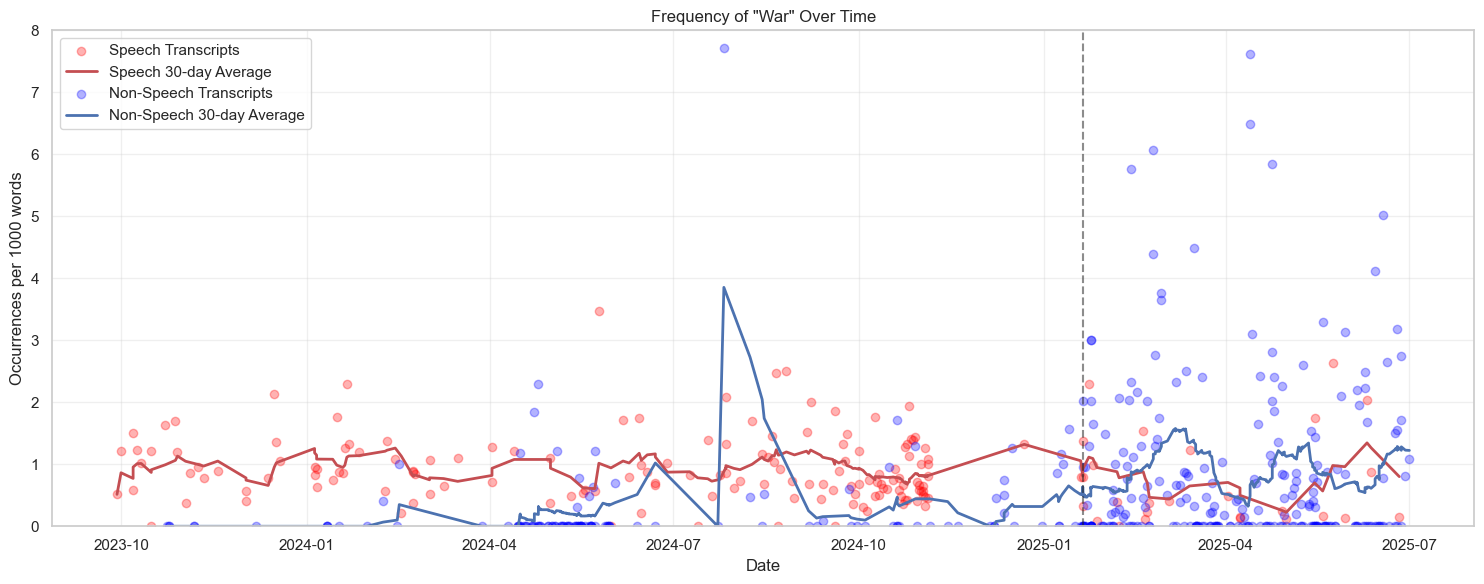

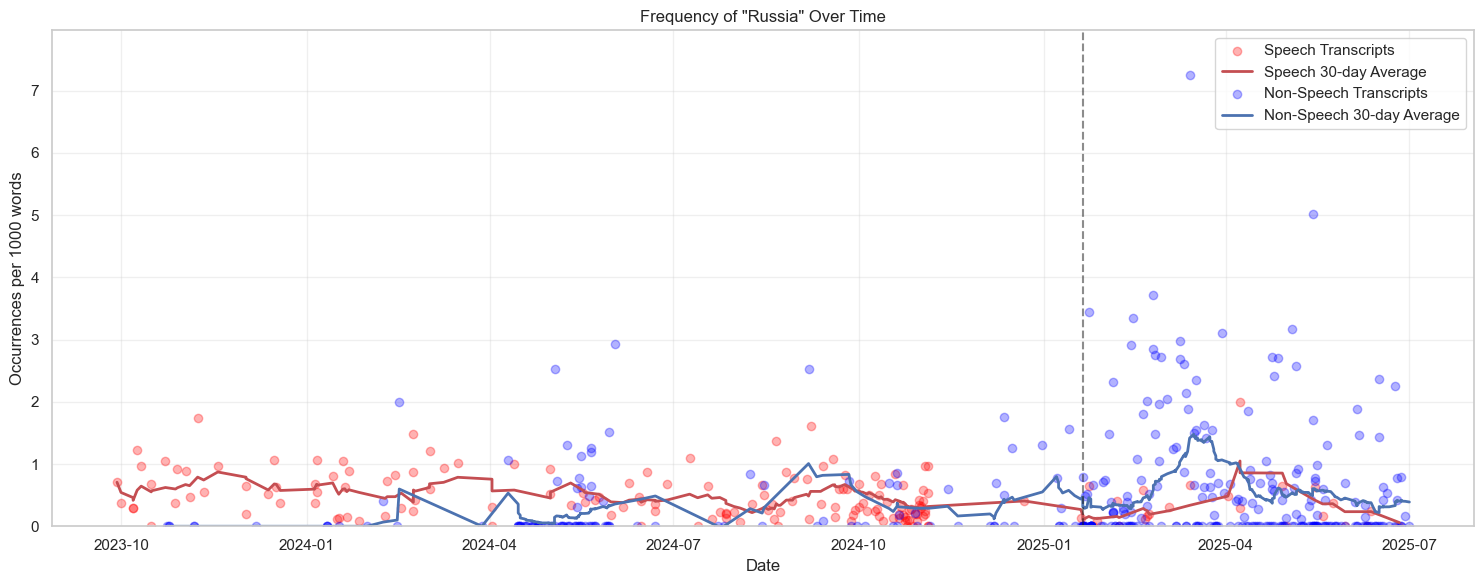

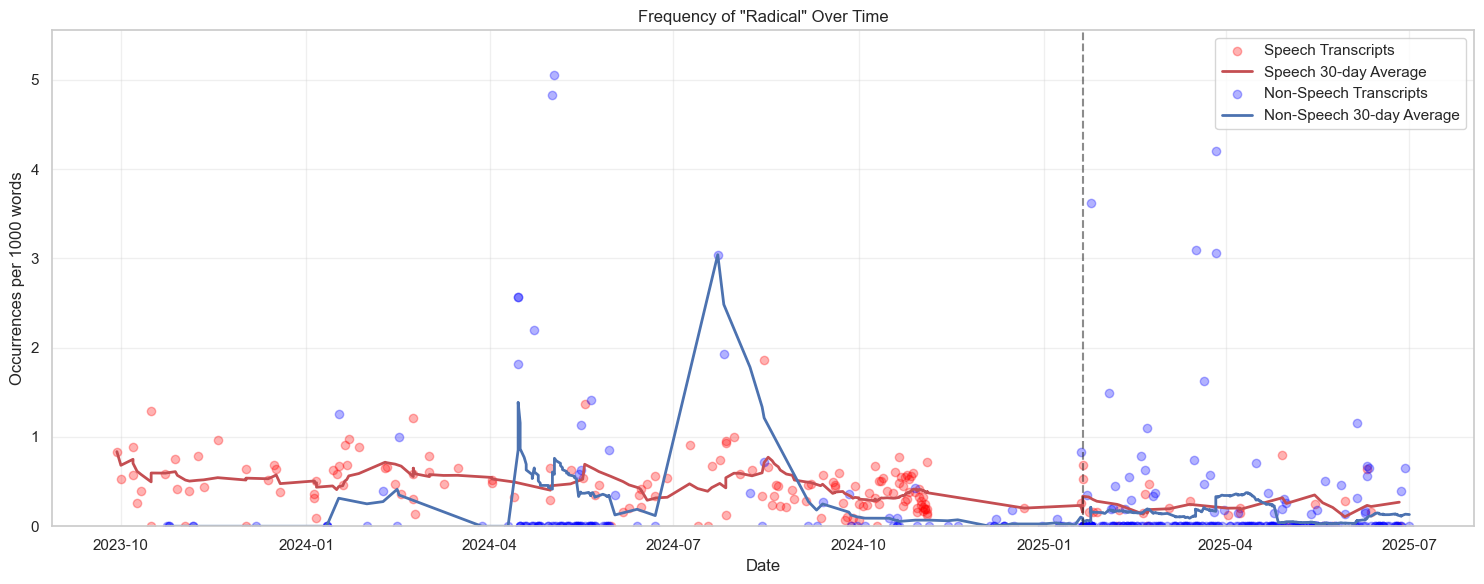

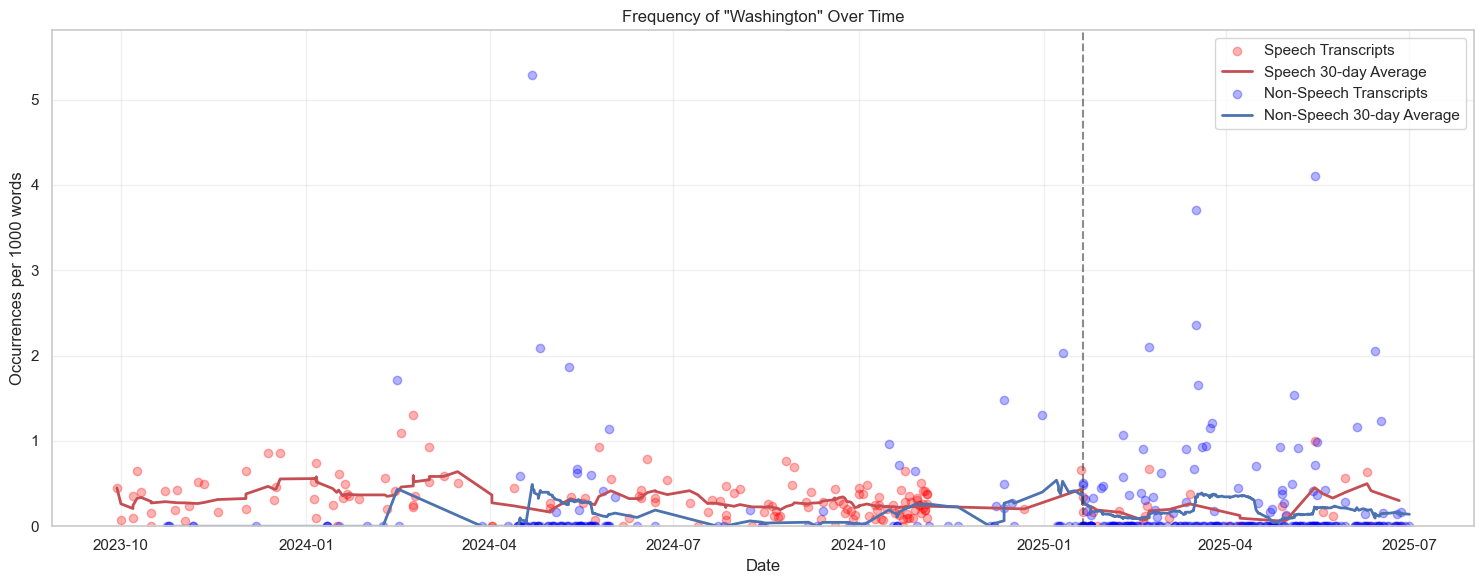

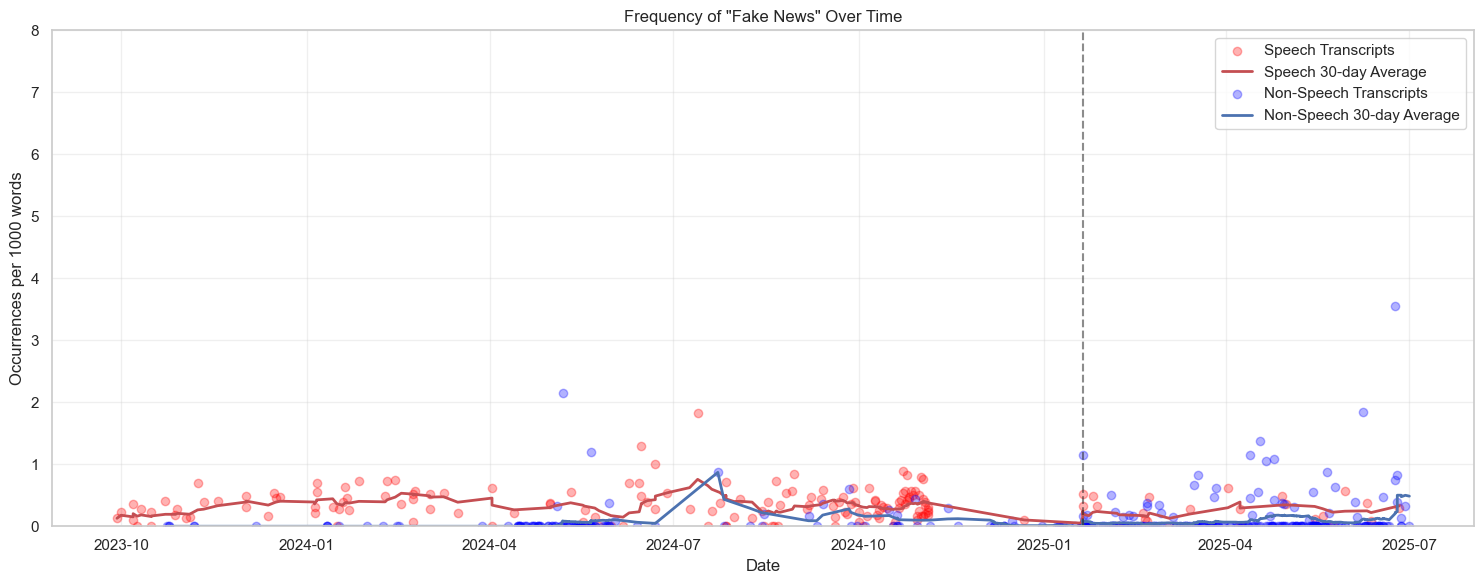

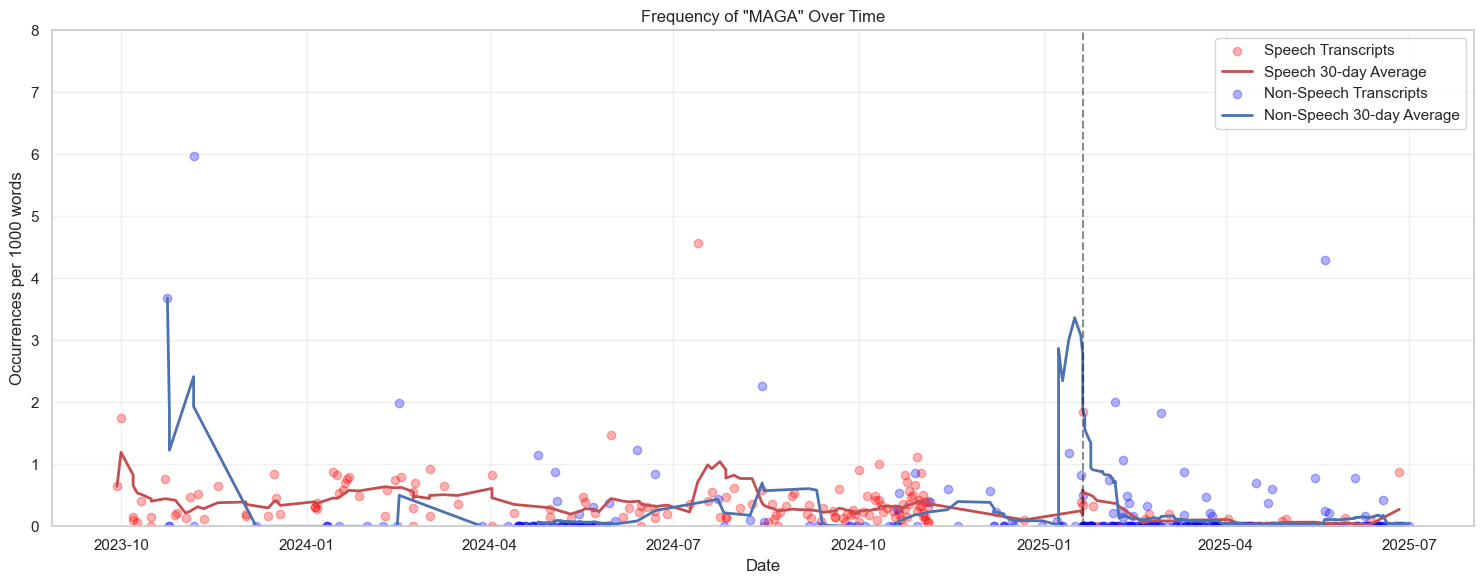

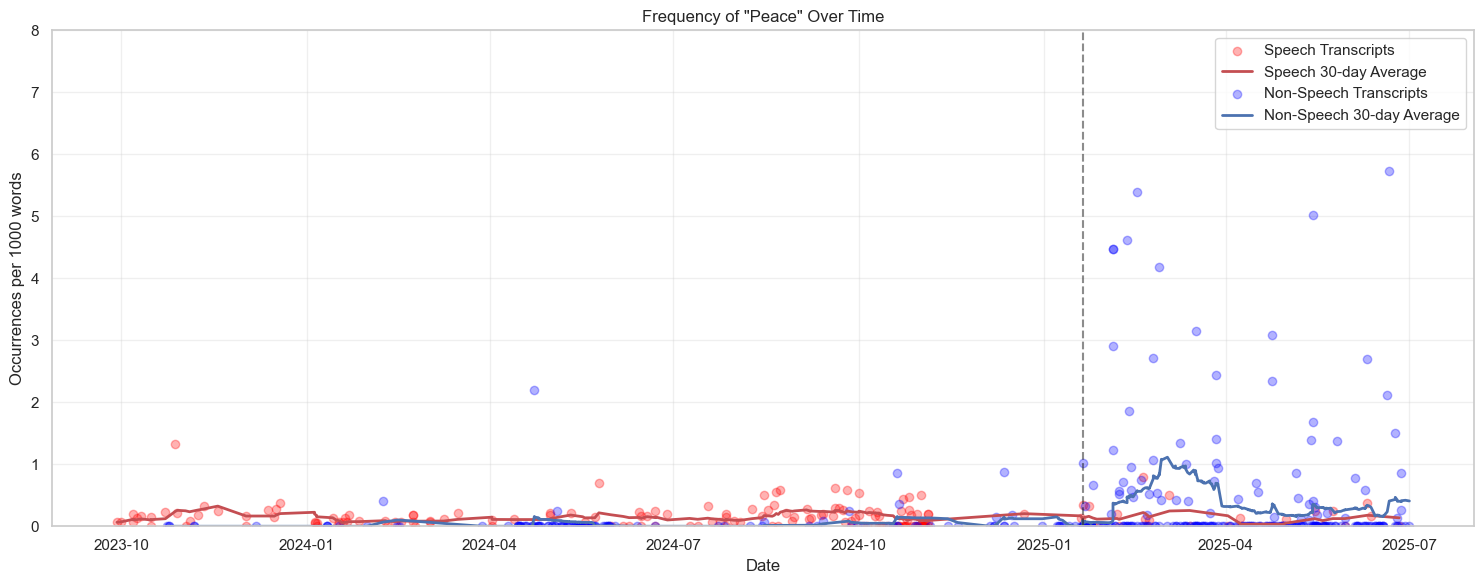

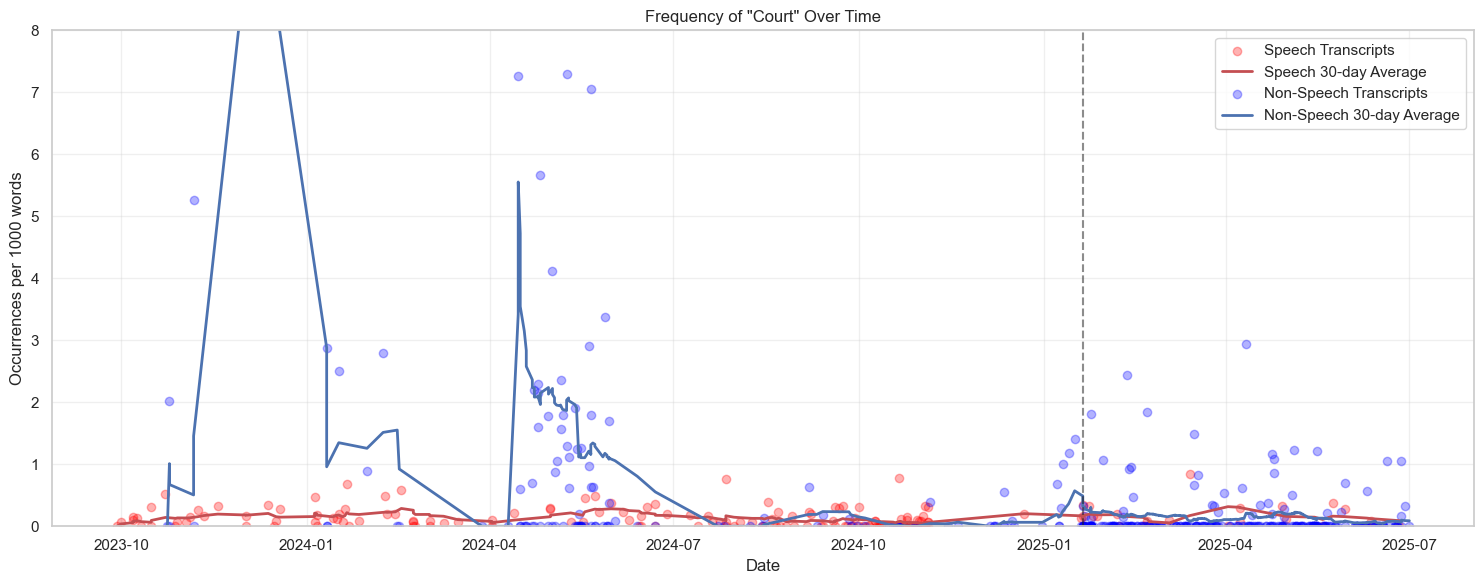

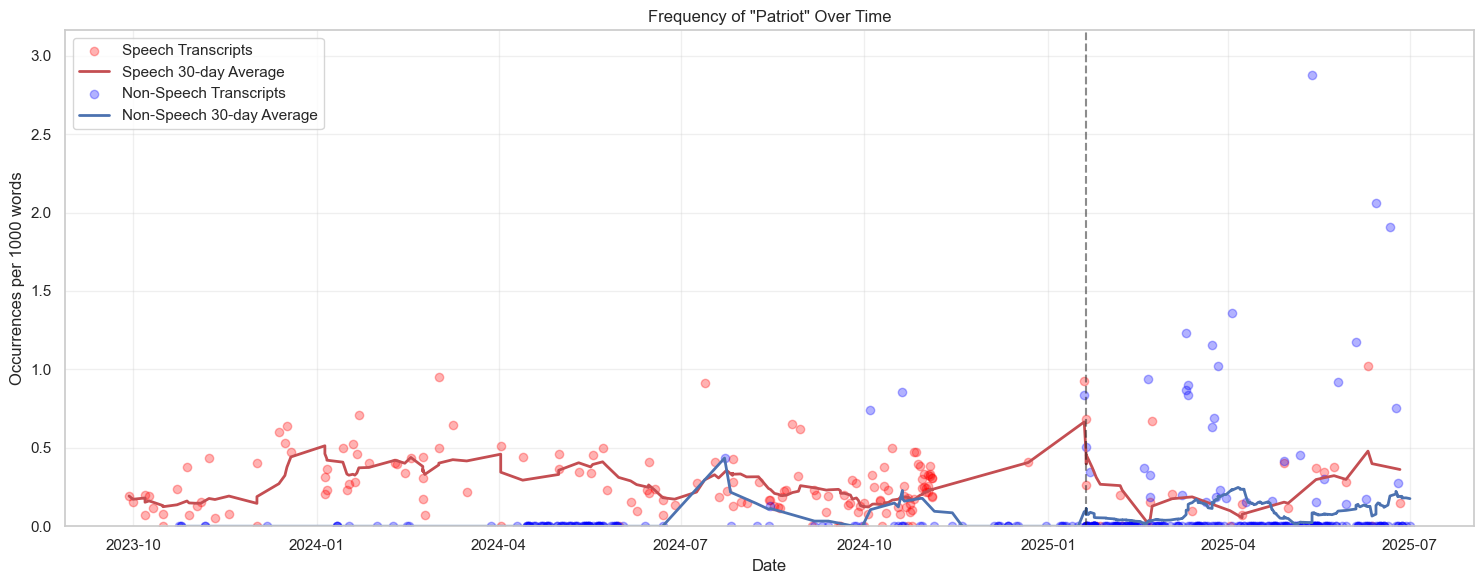

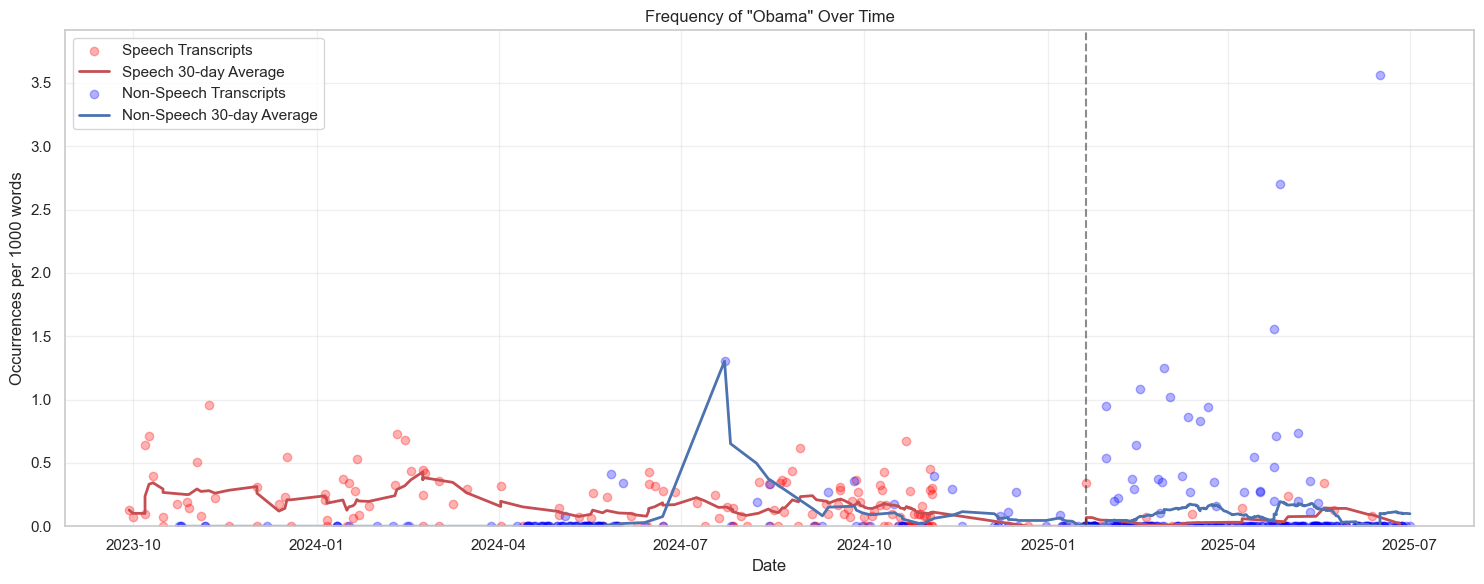

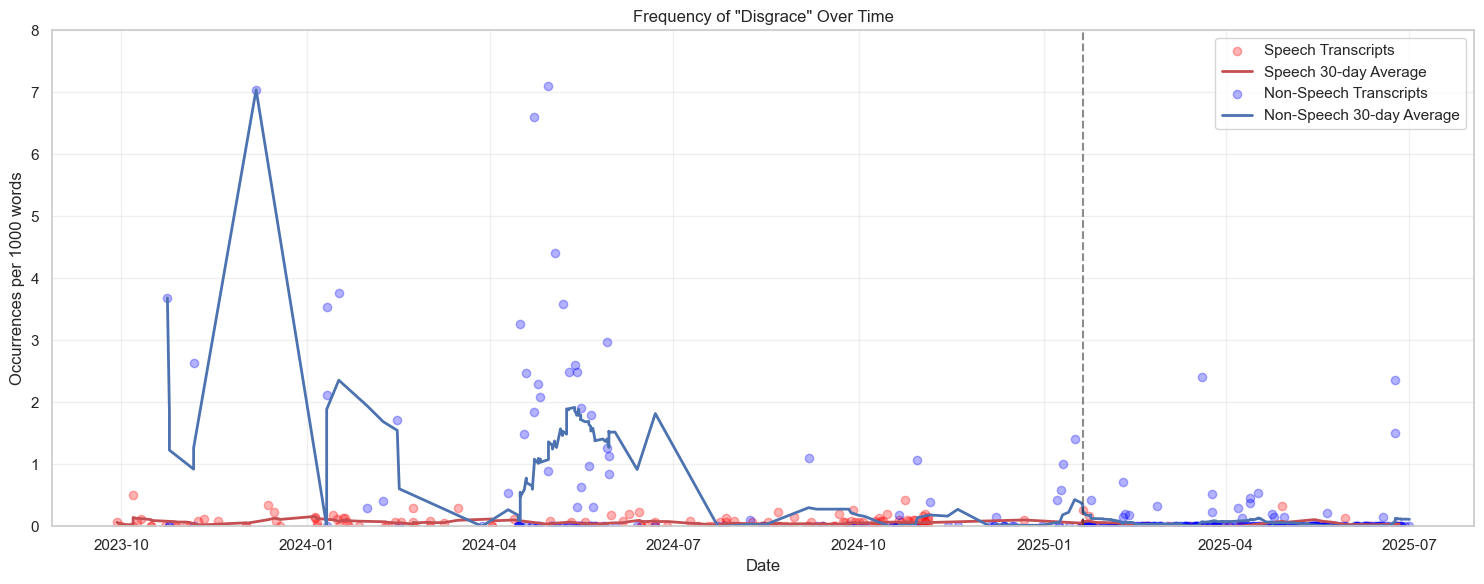

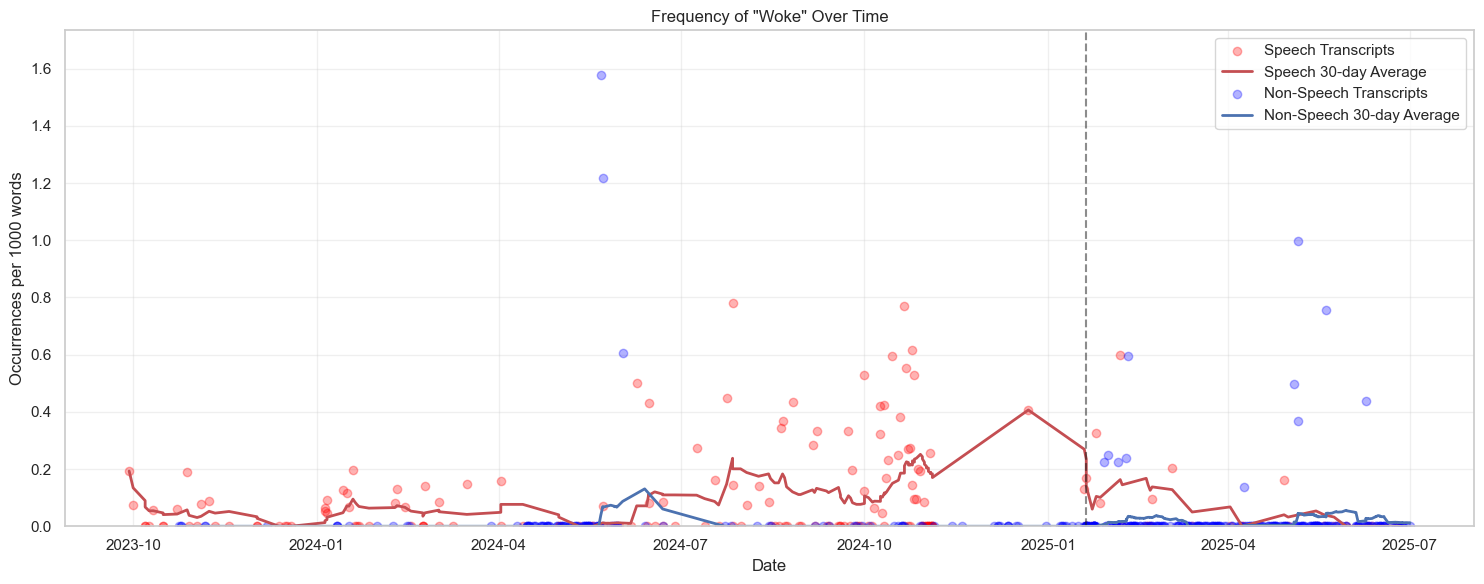

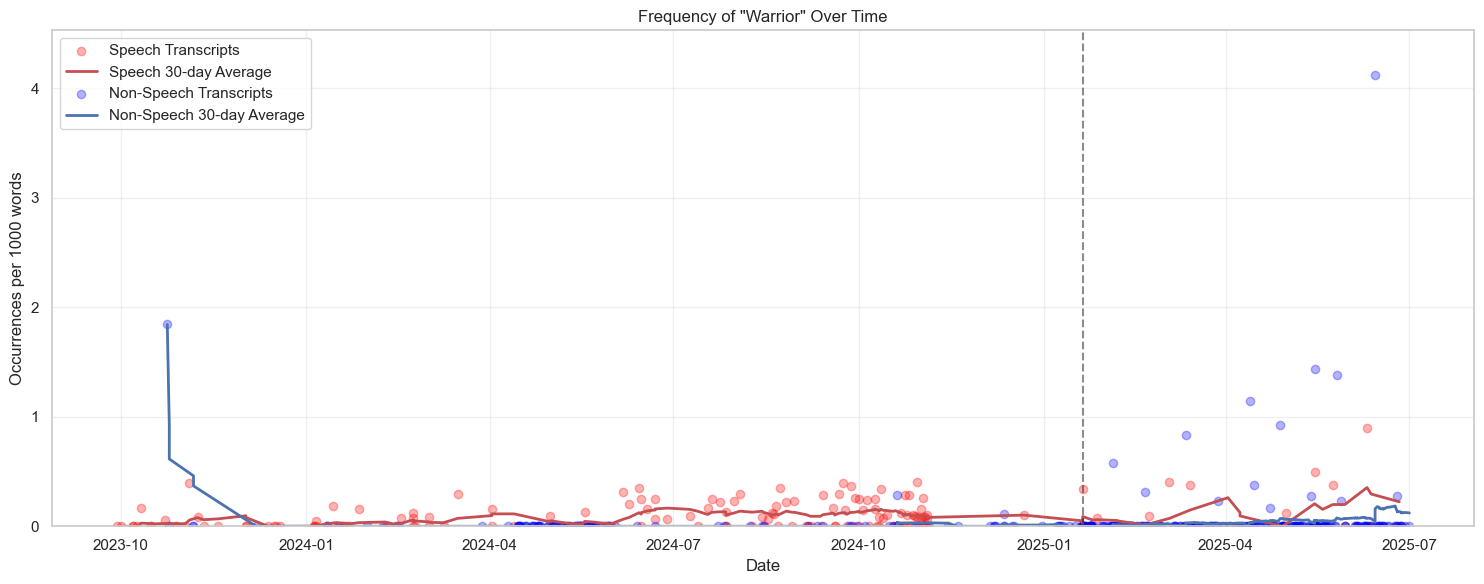

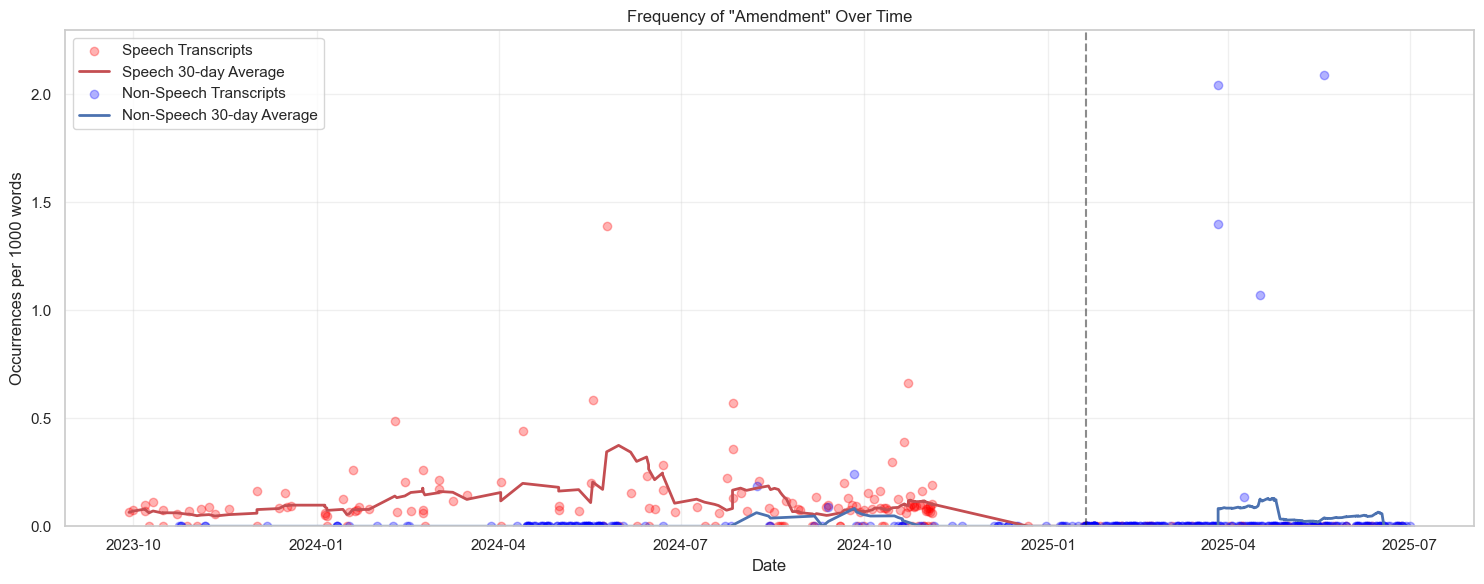

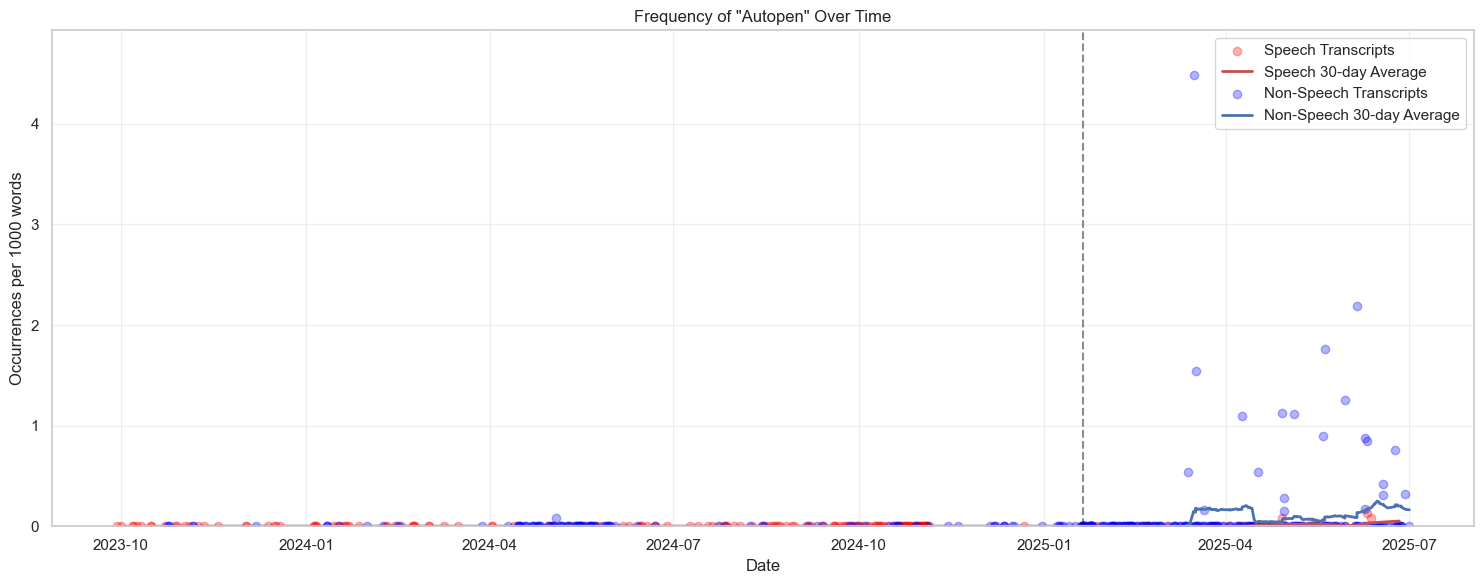

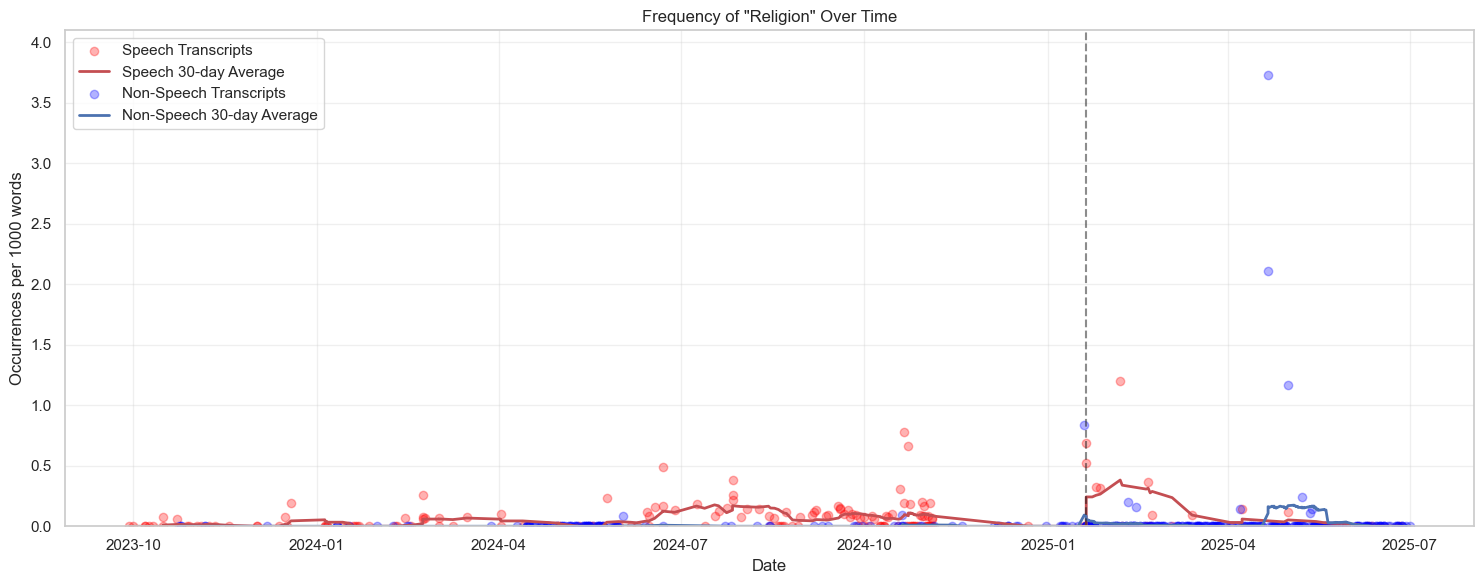

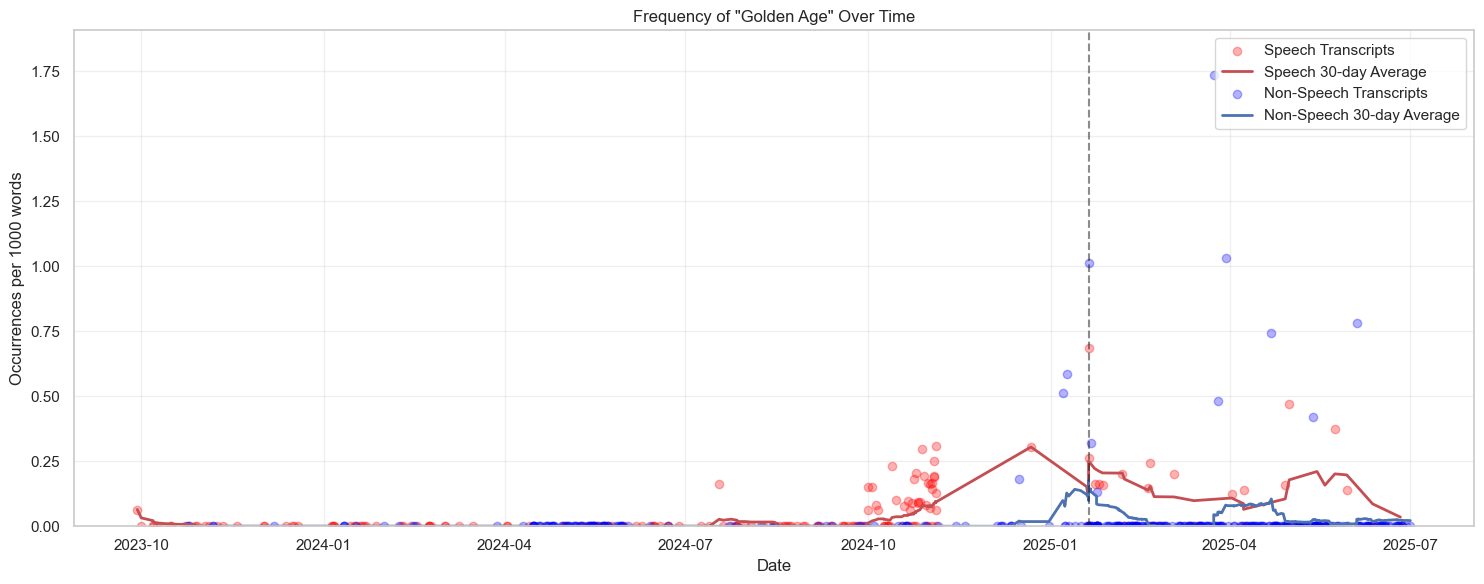

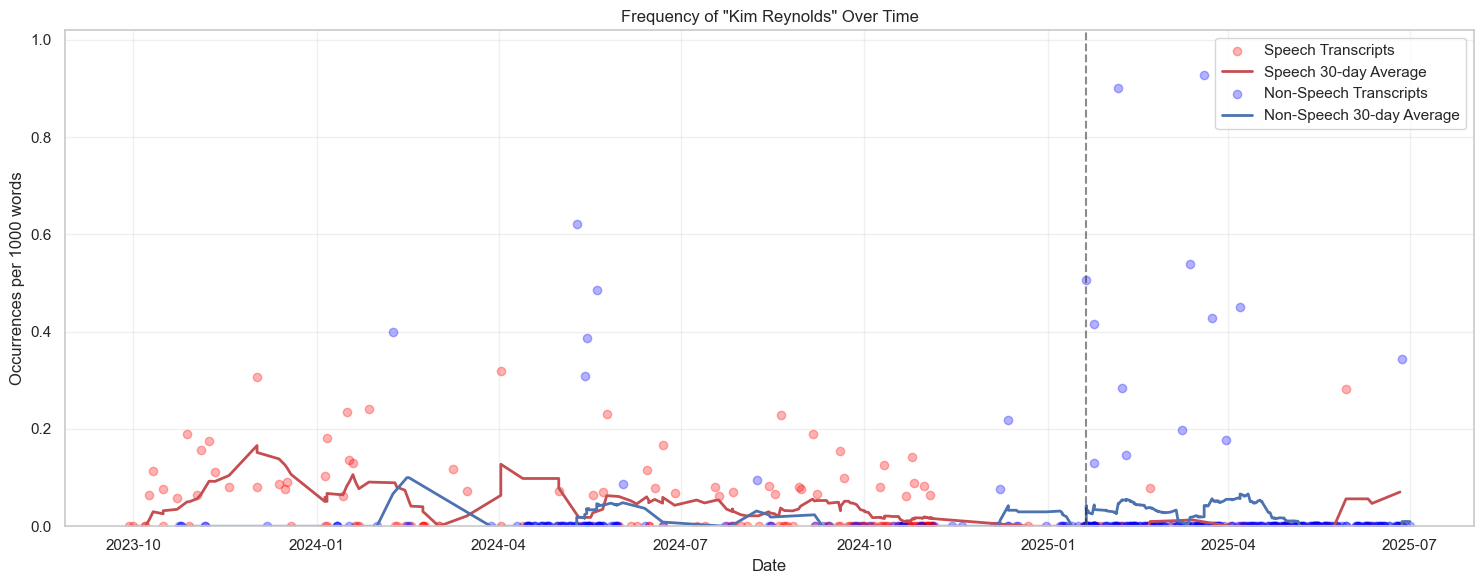

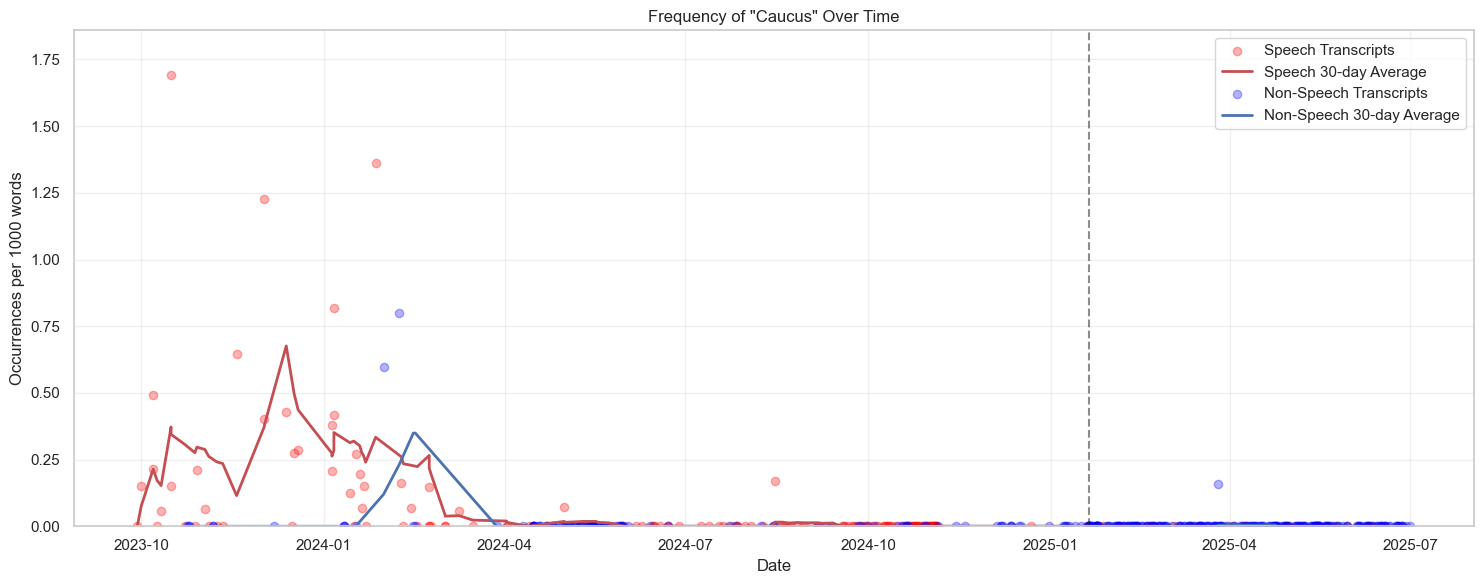

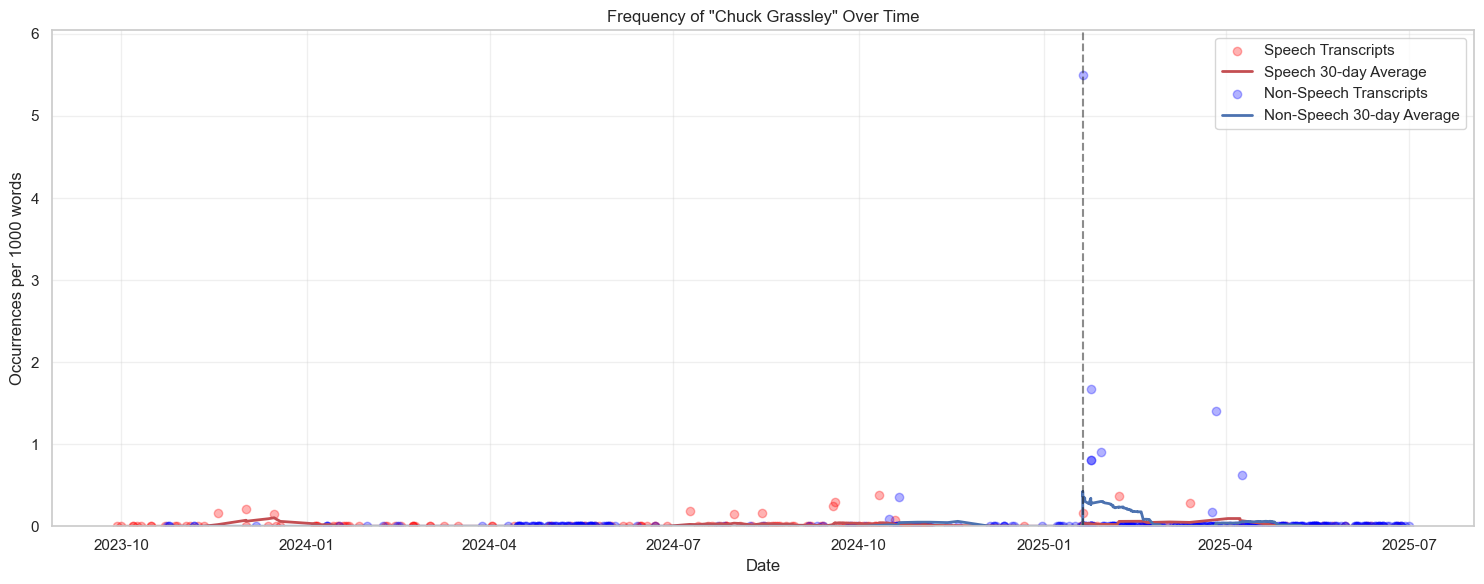

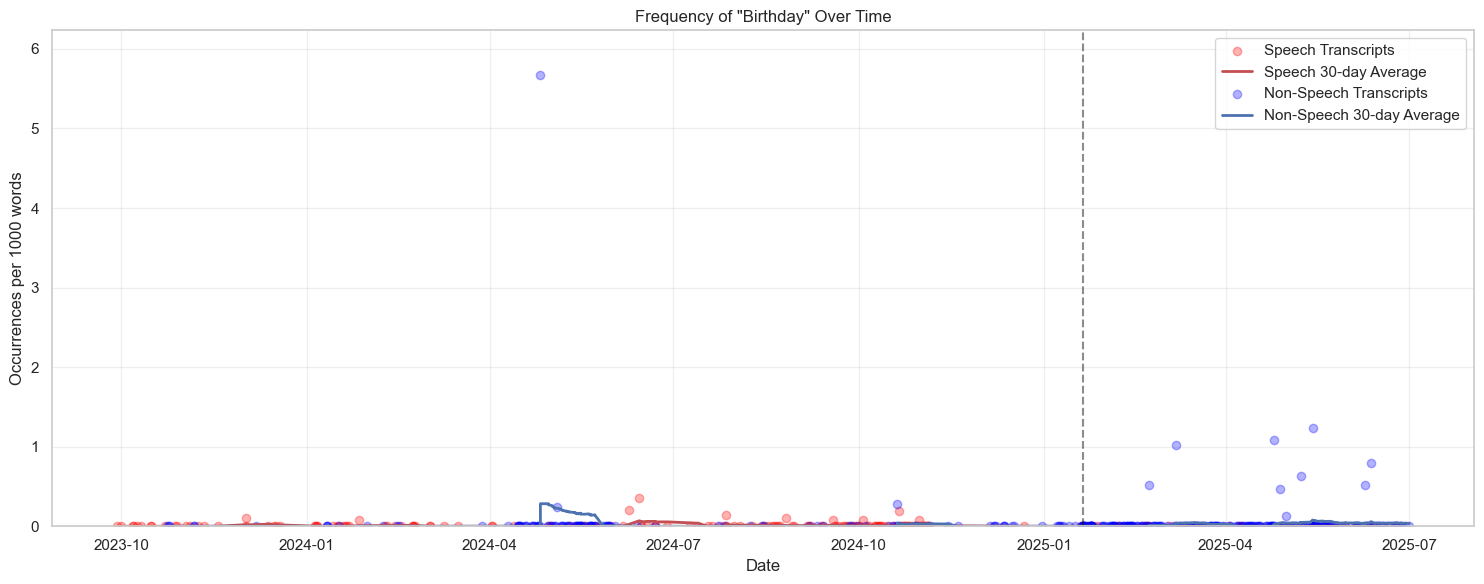

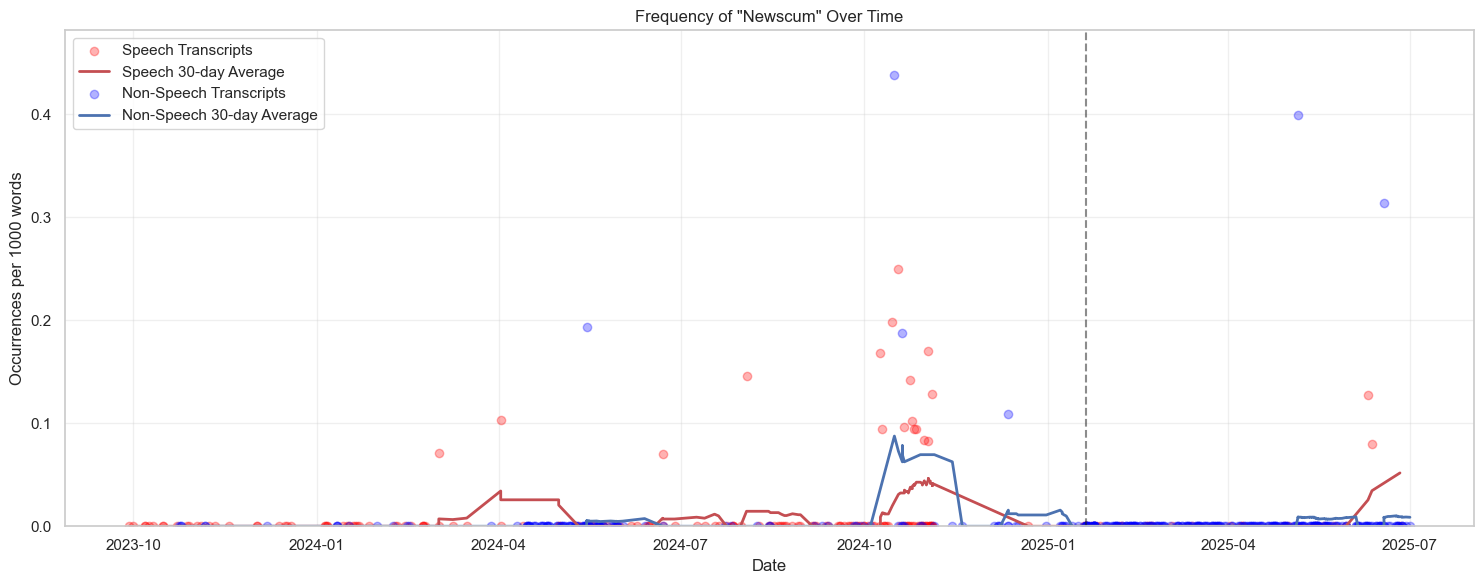

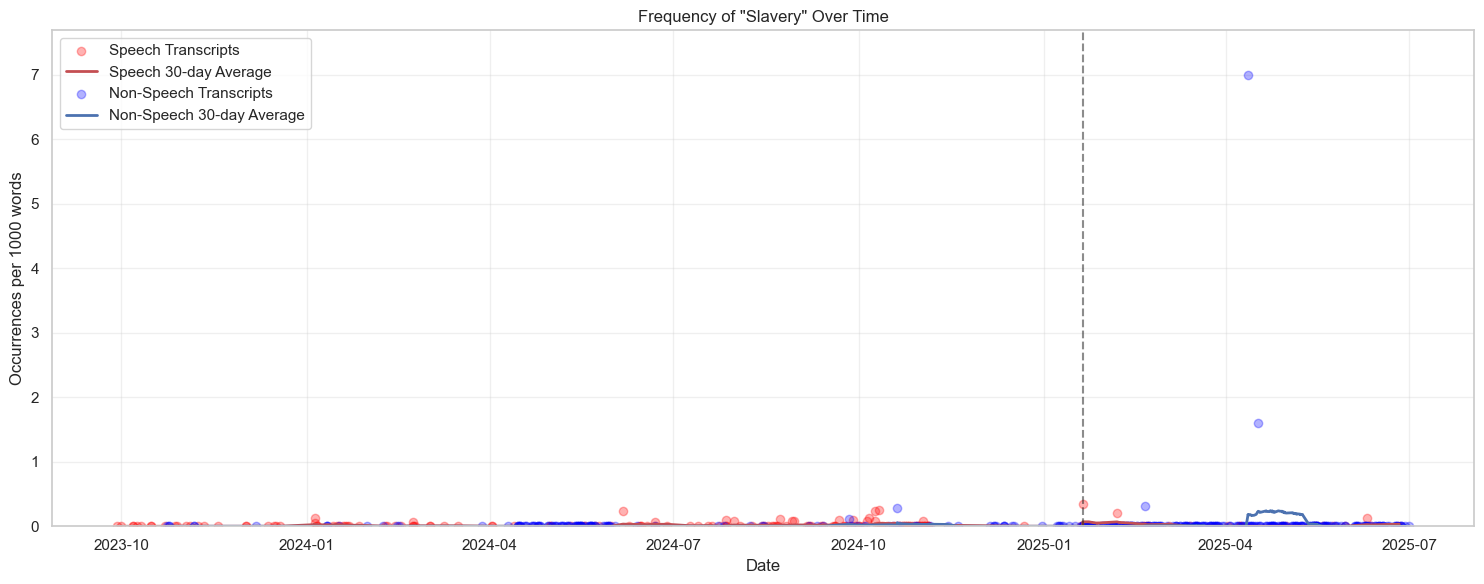

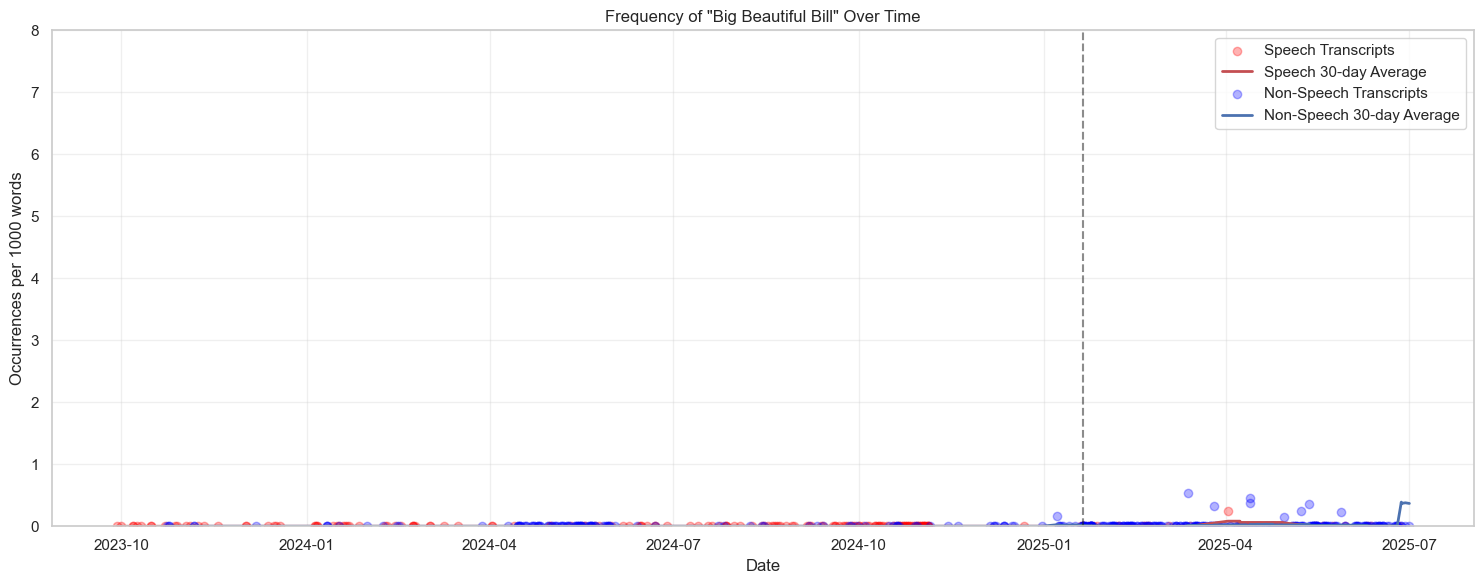

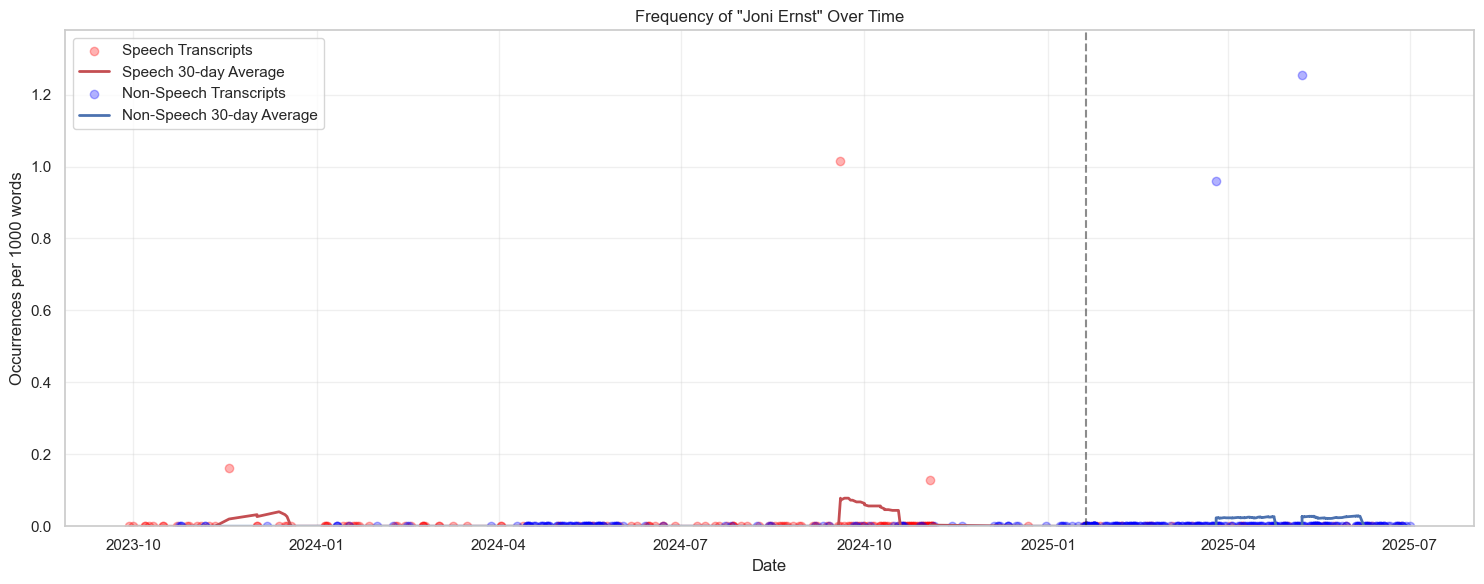

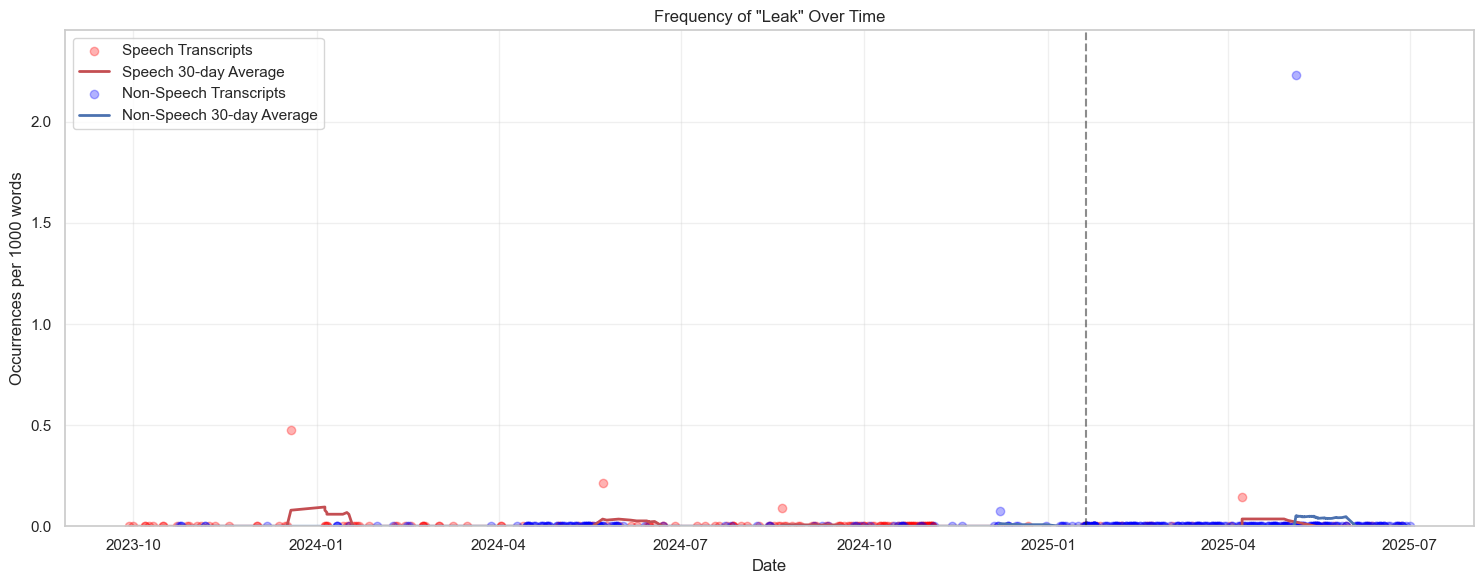

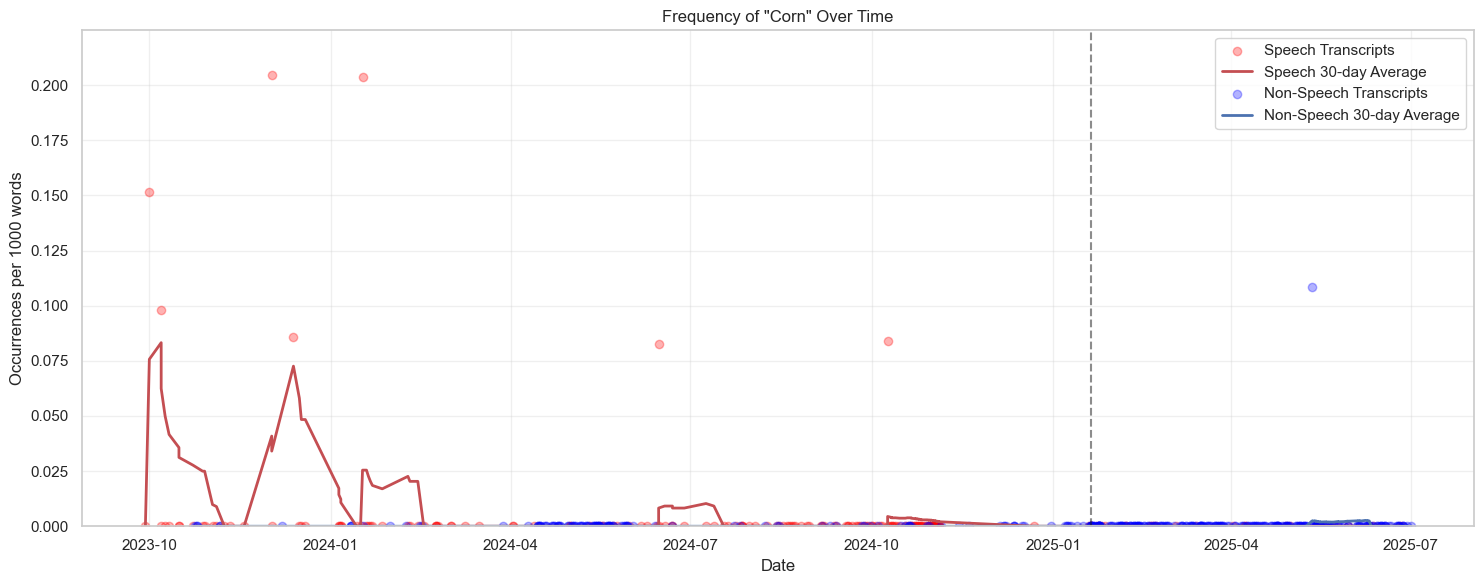

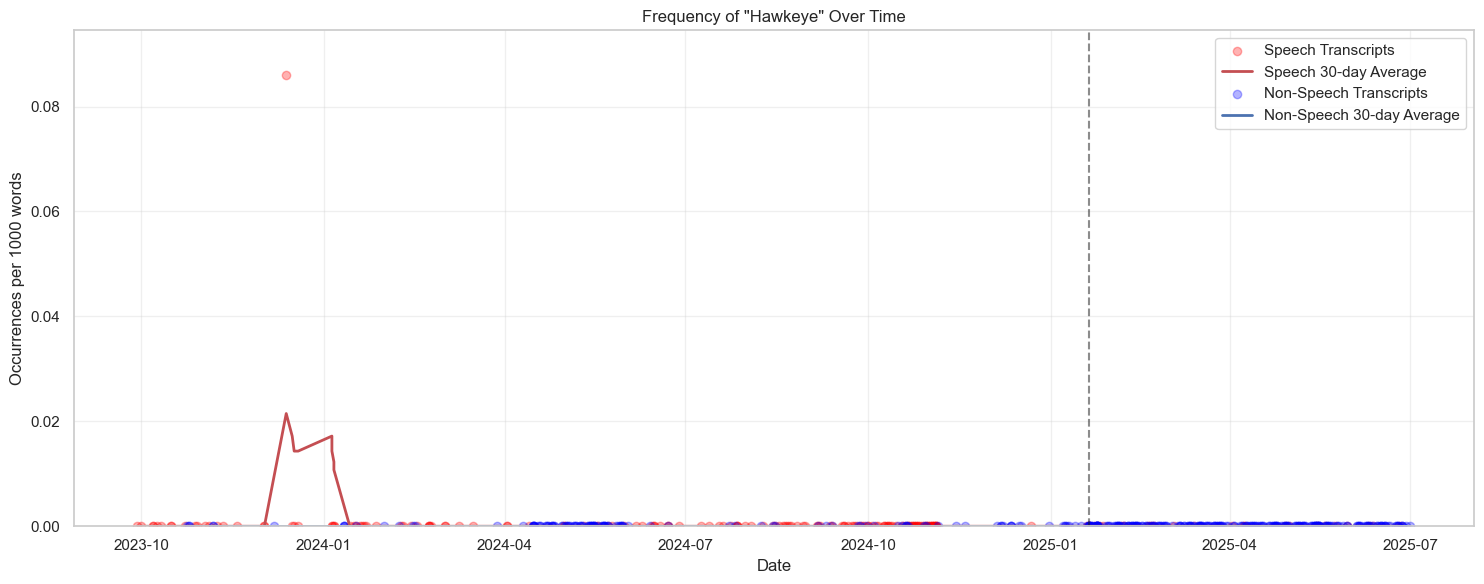

/var/folders/_t/ds12gpdx0qb6km94c759_z9m0000gn/T/ipykernel_14201/3705365225.py:39: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(0, ymax)


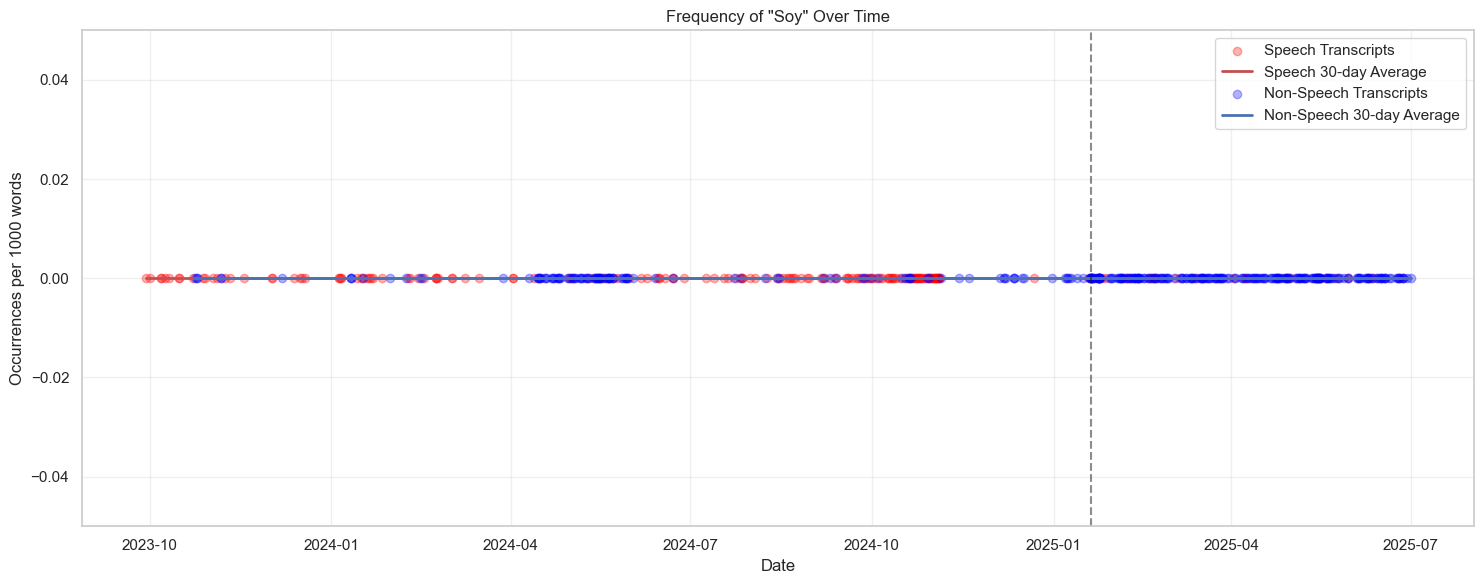

In [27]:
def plot_phrase_frequency_over_time(df_speech, df_non_speech, phrase, window=30):
    """Plot the frequency of a phrase over time with separate lines for speech and non-speech"""
    plt.figure(figsize=(15, 6))
    
    # Process speech data
    df_speech = df_speech.copy()
    df_speech[f'{phrase}_freq'] = (df_speech[phrase] / df_speech['text_length']) * 1000
    speech_series = df_speech.set_index('date')[f'{phrase}_freq']
    speech_rolling = speech_series.rolling(window=f'{window}D', min_periods=1).mean()
    
    # Process non-speech data
    df_non_speech = df_non_speech.copy()
    df_non_speech[f'{phrase}_freq'] = (df_non_speech[phrase] / df_non_speech['text_length']) * 1000
    non_speech_series = df_non_speech.set_index('date')[f'{phrase}_freq']
    non_speech_rolling = non_speech_series.rolling(window=f'{window}D', min_periods=1).mean()
    
    # Plot speech data
    plt.scatter(speech_series.index, speech_series.values, alpha=0.3, color='red', label='Speech Transcripts')
    plt.plot(speech_rolling.index, speech_rolling.values, 'r-', linewidth=2, label=f'Speech {window}-day Average')
    
    # Plot non-speech data
    plt.scatter(non_speech_series.index, non_speech_series.values, alpha=0.3, color='blue', label='Non-Speech Transcripts')
    plt.plot(non_speech_rolling.index, non_speech_rolling.values, 'b-', linewidth=2, label=f'Non-Speech {window}-day Average')
    
    plt.title(f'Frequency of "{phrase}" Over Time')
    plt.xlabel('Date')
    plt.ylabel('Occurrences per 1000 words')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add vertical line for inauguration
    plt.axvline(x=INAUGURATION_DATE, color='k', linestyle='--', alpha=0.5, label='Inauguration')
    
    # Auto-adjust y-axis limit up to max of 8
    ymax = min(8, max(
        df_speech[f'{phrase}_freq'].max(),
        df_non_speech[f'{phrase}_freq'].max()
    ) * 1.1)  # Add 10% padding
    plt.ylim(0, ymax)
    
    plt.tight_layout()
    plt.show()

# Plot time series for all phrases, sorted by frequency
phrase_freqs = {}
for phrase in SEARCH_PHRASES.keys():
    # Calculate average frequency across all data
    speech_freq = (df_speech[phrase].sum() / df_speech['text_length'].sum()) * 1000
    nonspeech_freq = (df_nonspeech[phrase].sum() / df_nonspeech['text_length'].sum()) * 1000
    phrase_freqs[phrase] = (speech_freq + nonspeech_freq) / 2

# Sort phrases by frequency and plot
for phrase in sorted(phrase_freqs, key=phrase_freqs.get, reverse=True):
    plot_phrase_frequency_over_time(df_speech, df_nonspeech, phrase)

In [28]:
# Search for military-related file names
military_terms = ['army', 'navy', 'military', 'fort', 'troop', 'base', 'marines', 'air force']
military_files = []

for _, row in df.iterrows():
    filename = row['file'].lower()
    if any(term in filename for term in military_terms):
        military_files.append(row['file'])

print("Files containing military-related terms:")
for file in military_files:
    print(f"- {file}")


Files containing military-related terms:
- 2023-11-18_donald_trump_holds_a_campaign_event_in_fort_dodge_iowa.txt
- 2025-05-08_donald_trump_attends_an_event_for_military_mothers.txt
- 2025-05-15_donald_trump_address_us_service_personnel_at_al_udeid_air_base_in_qatar.txt
- 2025-06-10_donald_trump_speaks_at_the_250th_anniversary_of_the_army_at_fort_liberty.txt
- 2025-06-14_donald_trump_administers_the_oath_to_us_army_soliders.txt
- 2025-06-14_donald_trump_and_jd_vance_speak_at_a_military_parade_in_washington.txt


In [29]:
# Load and analyze the specific Army anniversary speech
army_speech_file = '/Users/jstenger/Documents/repos/trump-speech/data/processed-transcripts/speech/2025-06-10_donald_trump_speaks_at_the_250th_anniversary_of_the_army_at_fort_liberty.txt'

try:
    with open(army_speech_file, 'r', encoding='utf-8') as f:
        army_speech_text = f.read()
    
    print(f"Army Anniversary Speech Analysis")
    print(f"File: {army_speech_file}")
    print(f"Text length: {len(army_speech_text.split())} words")
    print("\nPhrase occurrence counts:")
    print("-" * 40)
    
    # Count occurrences for each phrase
    army_speech_counts = {}
    for phrase, pattern in SEARCH_PHRASES.items():
        count = len(re.findall(pattern, army_speech_text, re.IGNORECASE))
        army_speech_counts[phrase] = count
        freq_per_1000 = (count / len(army_speech_text.split())) * 1000
        print(f"{phrase:15}: {count:2d} occurrences ({freq_per_1000:.1f} per 1000 words)")
    
    # Compare to historical averages
    print("\nComparison to historical speech averages:")
    print("-" * 50)
    for phrase in SEARCH_PHRASES.keys():
        historical_avg = (df_speech[phrase].sum() / df_speech['text_length'].sum()) * 1000
        actual_freq = (army_speech_counts[phrase] / len(army_speech_text.split())) * 1000
        ratio = actual_freq / historical_avg if historical_avg > 0 else float('inf')
        print(f"{phrase:15}: {actual_freq:5.1f} vs {historical_avg:5.1f} avg ({ratio:.1f}x)")

except FileNotFoundError:
    print(f"File not found: {army_speech_file}")
    print("Available speech files containing 'army' or 'fort':")
    army_related = df_speech[df_speech['file'].str.contains('army|fort', case=False, na=False)]
    for file in army_related['file'].values:
        print(f"- {file}")


Army Anniversary Speech Analysis
File: /Users/jstenger/Documents/repos/trump-speech/data/processed-transcripts/speech/2025-06-10_donald_trump_speaks_at_the_250th_anniversary_of_the_army_at_fort_liberty.txt
Text length: 7840 words

Phrase occurrence counts:
----------------------------------------
Court          :  0 occurrences (0.0 per 1000 words)
Big Beautiful Bill:  0 occurrences (0.0 per 1000 words)
Biden          :  3 occurrences (0.4 per 1000 words)
Peace          :  3 occurrences (0.4 per 1000 words)
MAGA           :  0 occurrences (0.0 per 1000 words)
Washington     :  5 occurrences (0.6 per 1000 words)
Patriot        :  8 occurrences (1.0 per 1000 words)
Joni Ernst     :  0 occurrences (0.0 per 1000 words)
War            : 16 occurrences (2.0 per 1000 words)
Radical        :  5 occurrences (0.6 per 1000 words)
Kim Reynolds   :  0 occurrences (0.0 per 1000 words)
Golden Age     :  0 occurrences (0.0 per 1000 words)
Fake News      :  3 occurrences (0.4 per 1000 words)
Chuck Gras

## Poisson Predictions

The most naive approach is to use the past frequency of a phrase over a given time period to forecast the probability of a phrase occurring during the expected length of a future speech. Using the Poisson distribution, we assume each word is independent and identically distributed. This allows us to compute threshold probabilities for a phrase occurring a given number of times, which can be compared to the prediction market's implied probability. However, this approach does not account for the clear dependence between words in a speech. This approach can still be useful for analyzing mentions where mostly independent occurrences might be expected (America, God, etc.) 

In [30]:
def calculate_poisson_predictions(df, avg_length):
    """Calculate predictions with likelihoods using Poisson distribution"""
    predictions = []
    
    for phrase in SEARCH_PHRASES.keys():
        # Calculate rate per word
        total_occurrences = df[phrase].sum()
        total_words = df['text_length'].sum()
        rate_per_word = total_occurrences / total_words
        
        # Expected occurrences in SOTU
        expected = rate_per_word * avg_length
        
        # Calculate likelihoods using Poisson PMF
        def poisson_ge_k(lambda_, k):
            return 1 - stats.poisson.cdf(k-1, lambda_)
        
        predictions.append({
            'Phrase': phrase,
            'Expected': expected,
            'Historical Rate': rate_per_word * 1000,  # per 1000 words
            'Total Historical': total_occurrences,
            'P(≥1)': poisson_ge_k(expected, 1),
            'P(≥3)': poisson_ge_k(expected, 3),
            'P(≥4)': poisson_ge_k(expected, 4),
            'P(≥5)': poisson_ge_k(expected, 5),
            'P(≥15)': poisson_ge_k(expected, 15)
        })
    
    return pd.DataFrame(predictions)

length = 10000

# Calculate predictions from different data sources
predictions_all = calculate_poisson_predictions(df, length)
predictions_speeches = calculate_poisson_predictions(df_speech, length)
predictions_post_all = calculate_poisson_predictions(pd.concat([df_nonspeech_post, df_speech_post]), length)

# Format the tables
def format_prediction_table(df, source):
    formatted = df.copy()
    formatted = formatted.round(2)
    formatted['P(≥1)'] = formatted['P(≥1)'].apply(lambda x: f"{x:.1%}")
    formatted['P(≥3)'] = formatted['P(≥3)'].apply(lambda x: f"{x:.1%}")
    formatted['P(≥4)'] = formatted['P(≥4)'].apply(lambda x: f"{x:.1%}")
    formatted['P(≥5)'] = formatted['P(≥5)'].apply(lambda x: f"{x:.1%}")
    formatted['P(≥15)'] = formatted['P(≥15)'].apply(lambda x: f"{x:.1%}")
    
    return formatted[[
        'Phrase', 'Expected',
        'P(≥1)', 'P(≥3)', 'P(≥4)', 'P(≥5)', 'P(≥15)',
        'Historical Rate', 'Total Historical'
    ]].sort_values('Expected', ascending=False)

print("Predictions based on all appearances:")
display(format_prediction_table(predictions_all, 'all'))

print("\nPredictions based on all speeches:")
display(format_prediction_table(predictions_speeches, 'post-inauguration-speeches'))

print("\nPredictions based on all post-inauguration appearances:")
display(format_prediction_table(predictions_post_all, 'post-inauguration-all'))

Predictions based on all appearances:


,Phrase,Expected,P(≥1),P(≥3),P(≥4),P(≥5),P(≥15),Historical Rate,Total Historical
2,Biden,13.94,100.0%,100.0%,100.0%,100.0%,42.0%,1.39,4108
8,War,9.01,100.0%,99.0%,98.0%,95.0%,4.0%,0.90,2655
18,Russia,5.51,100.0%,91.0%,80.0%,64.0%,0.0%,0.55,1623
9,Radical,3.48,97.0%,68.0%,46.0%,27.0%,0.0%,0.35,1027
12,Fake News,2.72,93.0%,51.0%,29.0%,14.0%,0.0%,0.27,803
5,Washington,2.70,93.0%,51.0%,29.0%,14.0%,0.0%,0.27,796
4,MAGA,2.66,93.0%,50.0%,28.0%,13.0%,0.0%,0.27,783
6,Patriot,1.98,86.0%,32.0%,14.0%,5.0%,0.0%,0.20,585
3,Peace,1.91,85.0%,30.0%,13.0%,4.0%,0.0%,0.19,563
0,Court,1.69,82.0%,24.0%,9.0%,3.0%,0.0%,0.17,499



Predictions based on all speeches:


,Phrase,Expected,P(≥1),P(≥3),P(≥4),P(≥5),P(≥15),Historical Rate,Total Historical
2,Biden,15.79,100.0%,100.0%,100.0%,100.0%,61.0%,1.58,3182
8,War,9.01,100.0%,99.0%,98.0%,95.0%,4.0%,0.90,1815
18,Russia,5.01,99.0%,88.0%,74.0%,56.0%,0.0%,0.50,1009
9,Radical,4.37,99.0%,81.0%,63.0%,44.0%,0.0%,0.44,880
4,MAGA,3.45,97.0%,67.0%,45.0%,27.0%,0.0%,0.34,695
12,Fake News,3.44,97.0%,67.0%,45.0%,26.0%,0.0%,0.34,693
5,Washington,3.13,96.0%,61.0%,38.0%,21.0%,0.0%,0.31,631
6,Patriot,2.56,92.0%,47.0%,26.0%,12.0%,0.0%,0.26,516
27,Obama,1.72,82.0%,25.0%,10.0%,3.0%,0.0%,0.17,347
3,Peace,1.39,75.0%,17.0%,5.0%,1.0%,0.0%,0.14,281



Predictions based on all post-inauguration appearances:


,Phrase,Expected,P(≥1),P(≥3),P(≥4),P(≥5),P(≥15),Historical Rate,Total Historical
8,War,9.52,100.0%,100.0%,99.0%,96.0%,6.0%,0.95,827
2,Biden,8.43,100.0%,99.0%,97.0%,92.0%,3.0%,0.84,732
18,Russia,5.89,100.0%,93.0%,84.0%,70.0%,0.0%,0.59,511
3,Peace,3.26,96.0%,63.0%,41.0%,23.0%,0.0%,0.33,283
5,Washington,1.67,81.0%,23.0%,9.0%,3.0%,0.0%,0.17,145
0,Court,1.53,78.0%,20.0%,7.0%,2.0%,0.0%,0.15,133
12,Fake News,1.51,78.0%,19.0%,7.0%,2.0%,0.0%,0.15,131
9,Radical,1.50,78.0%,19.0%,7.0%,2.0%,0.0%,0.15,130
6,Patriot,1.19,69.0%,12.0%,3.0%,1.0%,0.0%,0.12,103
27,Obama,1.00,63.0%,8.0%,2.0%,0.0%,0.0%,0.10,87


## Negative Binomial 

A more general model that accounts for overdispersion. The dispersion parameter r is estimated using the method of moments, and it controls how much extra variance there is compared to a Poisson distribution. As r approaches infinity, the negative binomial converges to a Poisson distribution (in practice we use r=100 to approximate this). Values closer to 0 indicate that the data is overdispersed.

Negative Binomial Predictions based on all appearances:


,Phrase,Expected,Dispersion (r),Sample Variance,P(≥1),P(≥3),P(≥4),P(≥5),P(≥15)
2,Biden,15.95,0.62,429.82,86.8%,72.9%,67.8%,63.4%,35.9%
8,War,10.31,0.54,208.83,80.0%,62.4%,56.5%,51.5%,23.9%
18,Russia,6.30,0.57,75.51,76.0%,54.2%,47.0%,41.1%,13.0%
9,Radical,3.99,0.44,40.11,63.8%,40.2%,33.3%,28.1%,6.6%
12,Fake News,3.12,0.35,30.71,55.3%,32.6%,26.6%,22.0%,4.7%
5,Washington,3.09,0.37,29.00,56.2%,33.0%,26.7%,22.0%,4.5%
4,MAGA,3.04,0.10,190.20,29.2%,18.6%,16.2%,14.3%,6.2%
6,Patriot,2.27,0.67,10.01,62.8%,31.3%,22.8%,16.8%,1.0%
3,Peace,2.19,0.10,93.04,26.9%,16.2%,13.7%,11.9%,4.4%
0,Court,1.94,0.10,157.90,26.0%,15.3%,12.9%,11.1%,3.8%


Negative Binomial Predictions based on all speeches:


,Phrase,Expected,Dispersion (r),Sample Variance,P(≥1),P(≥3),P(≥4),P(≥5),P(≥15)
2,Biden,18.08,1.68,212.52,98.4%,93.0%,89.6%,86.0%,50.0%
8,War,10.31,3.19,43.70,99.0%,92.6%,87.5%,81.4%,22.5%
18,Russia,5.73,2.61,18.34,95.2%,75.8%,64.5%,53.6%,4.3%
9,Radical,5.00,4.09,11.11,96.2%,75.6%,62.2%,49.1%,1.3%
4,MAGA,3.95,0.71,25.78,73.8%,46.5%,37.7%,30.8%,4.7%
12,Fake News,3.94,3.10,8.95,92.1%,62.8%,47.9%,35.2%,0.6%
5,Washington,3.58,3.59,7.16,91.7%,59.6%,43.7%,30.6%,0.2%
6,Patriot,2.93,3.93,5.12,88.8%,50.2%,33.5%,21.2%,0.0%
27,Obama,1.97,1.58,4.44,72.2%,30.3%,18.8%,11.4%,0.1%
3,Peace,1.60,0.97,4.23,61.0%,23.2%,14.4%,8.9%,0.1%


Negative Binomial Predictions based on all appearances post inauguration:


,Phrase,Expected,Dispersion (r),Sample Variance,P(≥1),P(≥3),P(≥4),P(≥5),P(≥15)
8,War,10.90,0.40,308.32,73.7%,56.7%,51.4%,47.1%,24.0%
2,Biden,9.65,0.80,125.73,87.2%,69.9%,63.2%,57.2%,22.9%
18,Russia,6.74,0.40,121.35,68.2%,48.4%,42.5%,37.8%,14.8%
3,Peace,3.73,0.10,179.05,30.6%,20.2%,17.7%,15.8%,7.5%
5,Washington,1.91,0.12,31.07,29.5%,16.8%,13.9%,11.8%,3.5%
0,Court,1.75,0.19,18.08,35.6%,18.7%,14.8%,12.1%,2.4%
12,Fake News,1.73,0.10,50.60,25.2%,14.5%,12.0%,10.3%,3.3%
9,Radical,1.71,0.10,30.33,25.5%,14.6%,12.1%,10.3%,3.2%
6,Patriot,1.36,0.14,14.84,27.9%,14.3%,11.3%,9.2%,1.9%
27,Obama,1.15,0.10,15.56,22.3%,11.5%,9.2%,7.6%,1.7%



Model Comparison (Negative Binomial vs Poisson):


,Phrase,Expected,Poisson P(≥1),NB P(≥1),Δ P(≥1),Poisson P(≥5),NB P(≥5),Δ P(≥5),Dispersion (r),Sample Variance
11,Golden Age,1.402,75.4%,24.6%,-50.810,1.4%,1.6%,0.171,0.290,1.263
21,Religion,1.194,69.7%,28.9%,-40.832,0.8%,4.2%,3.429,0.243,3.022
17,Warrior,1.350,74.1%,47.2%,-26.926,1.2%,3.9%,2.662,0.750,2.355
3,Peace,1.766,82.9%,61.0%,-21.852,3.4%,8.9%,5.503,0.967,4.234
0,Court,1.714,82.0%,61.0%,-21.005,3.0%,7.5%,4.467,1.082,3.580
13,Chuck Grassley,0.312,26.8%,8.9%,-17.893,0.0%,0.4%,0.381,0.100,0.500
16,Autopen,0.156,14.4%,1.6%,-12.865,0.0%,0.0%,0.000,0.100,0.021
1,Big Beautiful Bill,0.104,9.9%,1.1%,-8.795,0.0%,0.0%,0.000,0.100,0.045
28,Slavery,0.156,14.4%,10.4%,-4.064,0.0%,0.2%,0.226,0.155,0.323
18,Russia,4.414,98.8%,95.2%,-3.615,45.2%,53.6%,8.441,2.606,18.343



Distribution comparison for MAGA (r = 0.71):


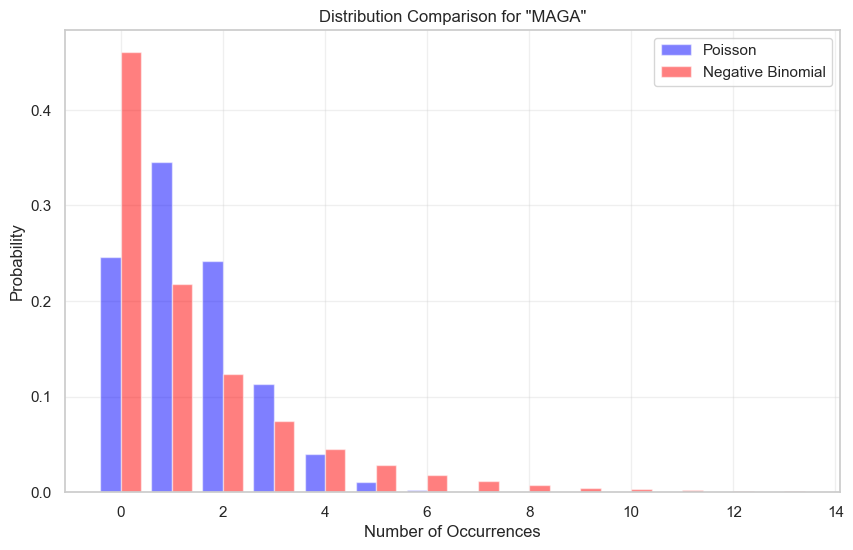

In [31]:

def calculate_negative_binomial_predictions(df, avg_length):
    """Calculate predictions using Negative Binomial distribution"""
    predictions = []
    
    for phrase in SEARCH_PHRASES.keys():
        # Calculate rate per word and variance
        total_occurrences = df[phrase].sum()
        total_words = df['text_length'].sum()
        rate_per_word = total_occurrences / total_words
        
        # Expected occurrences in speech of avg_length
        expected = rate_per_word * avg_length
        
        # Calculate sample variance to estimate overdispersion
        counts_per_speech = df[phrase] / df['text_length'] * avg_length
        sample_variance = counts_per_speech.var()
        
        if sample_variance > expected and expected > 0:  # Check for overdispersion
            # Calculate r parameter for negative binomial using method of moments
            r = max(0.1, expected**2 / (sample_variance - expected))
            p = r/(r + expected)
        else:
            # If no overdispersion, fallback to quasi-Poisson
            r = 100
            p = r/(r + expected)
        
        # Calculate likelihoods using Negative Binomial CDF
        def nb_ge_k(r, p, k):
            return 1 - stats.nbinom.cdf(k-1, r, p)
        
        predictions.append({
            'Phrase': phrase,
            'Expected': expected,
            'Dispersion (r)': r,
            'Sample Variance': sample_variance,
            'P(≥1)': nb_ge_k(r, p, 1),
            'P(≥3)': nb_ge_k(r, p, 3),
            'P(≥4)': nb_ge_k(r, p, 4),
            'P(≥5)': nb_ge_k(r, p, 5),
            'P(≥15)': nb_ge_k(r, p, 15)
        })
    
    return pd.DataFrame(predictions)


def format_prediction_table(df):
    """Format prediction table with percentages"""
    formatted = df.copy()
    formatted = formatted.round(3)
    
    # Format probability columns as percentages
    prob_columns = ['P(≥1)', 'P(≥3)', 'P(≥4)', 'P(≥5)', 'P(≥15)']
    for col in prob_columns:
        formatted[col] = formatted[col].map('{:.1%}'.format)
    
    # Round other numeric columns
    formatted['Expected'] = formatted['Expected'].round(2)
    if 'Dispersion (r)' in formatted.columns:
        formatted['Dispersion (r)'] = formatted['Dispersion (r)'].round(2)
        formatted['Sample Variance'] = formatted['Sample Variance'].round(2)
    
    return formatted.sort_values('Expected', ascending=False)

def compare_models(poisson_df, nb_df):
    """Compare Poisson and Negative Binomial predictions"""
    comparison = pd.DataFrame()
    comparison['Phrase'] = poisson_df['Phrase']
    comparison['Expected'] = poisson_df['Expected']
    
    # Convert percentage strings back to floats for calculations
    for k in [1, 5]:
        # Get raw probability values directly
        comparison[f'Poisson P(≥{k})'] = poisson_df[f'P(≥{k})'].astype(float)
        comparison[f'NB P(≥{k})'] = nb_df[f'P(≥{k})'].astype(float)
        comparison[f'Δ P(≥{k})'] = (comparison[f'NB P(≥{k})'] - comparison[f'Poisson P(≥{k})']) * 100
    
    comparison['Dispersion (r)'] = nb_df['Dispersion (r)']
    comparison['Sample Variance'] = nb_df['Sample Variance']
    
    # Format probability columns as percentages
    for col in comparison.columns:
        if 'P(≥' in col and 'Δ' not in col:
            comparison[col] = comparison[col].map('{:.1%}'.format)
    
    return comparison.round(3).sort_values('Δ P(≥1)', ascending=True)

def plot_distribution_comparison(phrase, poisson_df, nb_df, max_k=10):
    """Plot comparison of Poisson and Negative Binomial distributions"""
    phrase_data = poisson_df[poisson_df['Phrase'] == phrase].iloc[0]
    nb_data = nb_df[nb_df['Phrase'] == phrase].iloc[0]
    
    lambda_ = phrase_data['Expected']
    r = nb_data['Dispersion (r)']
    p = r/(r + lambda_)
    
    k = np.arange(0, max_k+1)
    poisson_pmf = stats.poisson.pmf(k, lambda_)
    nb_pmf = stats.nbinom.pmf(k, r, p)
    
    plt.figure(figsize=(10, 6))
    plt.bar(k-0.2, poisson_pmf, width=0.4, alpha=0.5, label='Poisson', color='blue')
    plt.bar(k+0.2, nb_pmf, width=0.4, alpha=0.5, label='Negative Binomial', color='red')
    plt.title(f'Distribution Comparison for "{phrase}"')
    plt.xlabel('Number of Occurrences')
    plt.ylabel('Probability')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Calculate predictions using both models
avg_speech_length = df_speech['text_length'].mean()

print("Negative Binomial Predictions based on all appearances:")
nb_predictions = calculate_negative_binomial_predictions(df, avg_speech_length)
display(format_prediction_table(nb_predictions))

print("Negative Binomial Predictions based on all speeches:")
nb_predictions = calculate_negative_binomial_predictions(df_speech, avg_speech_length)
display(format_prediction_table(nb_predictions))


print("Negative Binomial Predictions based on all appearances post inauguration:")
nb_predictions_all = calculate_negative_binomial_predictions(df_post, avg_speech_length)
display(format_prediction_table(nb_predictions_all))

poisson_predictions = calculate_poisson_predictions(df_speech_post, avg_speech_length)

print("\nModel Comparison (Negative Binomial vs Poisson):")
display(compare_models(poisson_predictions, nb_predictions))

# Plot distributions for most overdispersed phrases
most_overdispersed = nb_predictions[nb_predictions['Phrase'].isin(['Border', 'America', 'God', 'January 6', 'MAGA', 'LA', 'Rigged', 'Hell'])]
for _, row in most_overdispersed.iterrows():
    # Get parameters for both distributions
    phrase_data = poisson_predictions[poisson_predictions['Phrase'] == row['Phrase']].iloc[0]
    lambda_ = phrase_data['Expected']
    r = row['Dispersion (r)']
    p = r/(r + lambda_)
    
    # Find where probability becomes negligible (< 0.1%)
    k = 0
    while stats.nbinom.pmf(k, r, p) > 0.001 or stats.poisson.pmf(k, lambda_) > 0.001:
        k += 1
    
    # Ensure minimum k of 30 for 'America' to show full distribution
    if row['Phrase'] == 'America':
        k = max(k, 60)
    
    print(f"\nDistribution comparison for {row['Phrase']} (r = {row['Dispersion (r)']:.2f}):")
    plot_distribution_comparison(row['Phrase'], poisson_predictions, nb_predictions, max_k=k)

In [41]:
avg_speech_length



np.float64(11446.676136363636)

In [32]:
avg_speech_length

np.float64(11446.676136363636)

## Recent Usage in context

In [33]:
def get_recent_contexts(df, phrase, n=5):
    """Get the n most recent contexts for a phrase"""
    # Create a list to store matches with their dates
    all_matches = []
    
    # Look through speeches from newest to oldest
    for _, row in df.sort_values('date', ascending=False).iterrows():
        matches = find_phrase_context(row['text'], SEARCH_PHRASES[phrase])
        for match in matches:
            all_matches.append({
                'date': row['date'],
                'category': row['category'],
                'context': match
            })
        if len(all_matches) >= n:
            break
    
    return pd.DataFrame(all_matches[:n])

# Get recent contexts for each phrase
for phrase in SEARCH_PHRASES.keys():
    contexts = get_recent_contexts(df_speech, phrase)
    if not contexts.empty:
        print(f"\n=== Recent usage of '{phrase}' ===\n")
        for _, row in contexts.iterrows():
            print(f"Date: {row['date'].strftime('%Y-%m-%d')} ({row['category']})")
            print(f"Context: {row['context']}\n")


=== Recent usage of 'Court' ===

Date: 2025-06-12 (speech)
Context: ...nteresting.  Why did I ask that question, Mr. Speaker?  But in a few moments, I'll sign three pieces of legislation that will kill, totally kill. You can't do anything about it. They can't take us to court.

They can't do any of the things they can do with the executive orders. And it's permanent. I'll sign three pieces of legislation that will kill the California mandates forever. And they're never co...

Date: 2025-05-30 (speech)
Context: ...s to happen to our country, but we're moving them out and we're moving them out fast.

And we're bringing them back to where they came from. We're having a lot of problems with the liberal judges and courts. The radical left crazy judges that -- you know, they come in without courts. They pour into our country totally unvetted and unchecked. Nobody checked him. Nobody had any idea who they were, 11,888 ...

Date: 2025-05-30 (speech)
Context: ...ut fast.

And we're bringing th

## Per-Speech Frequencies


/var/folders/_t/ds12gpdx0qb6km94c759_z9m0000gn/T/ipykernel_14201/1107231187.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


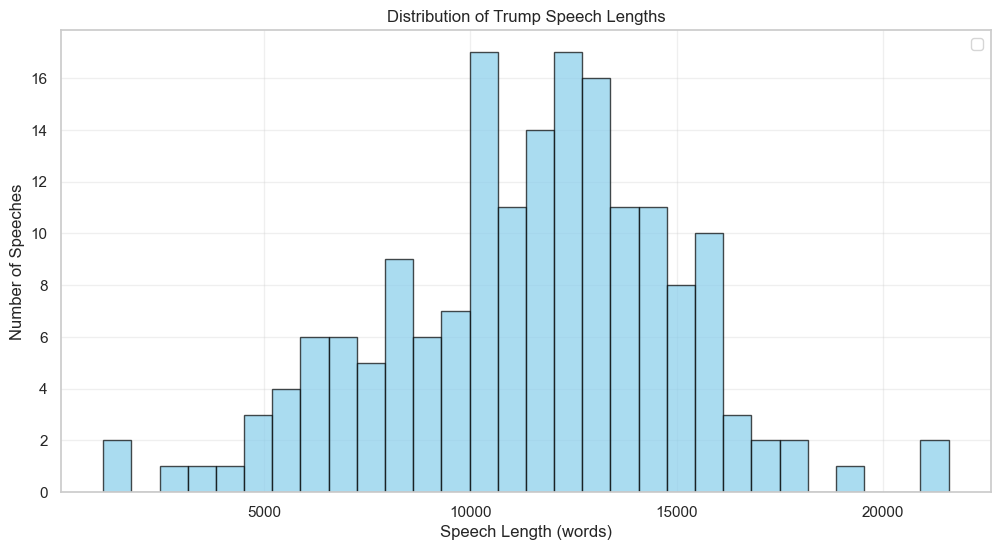

In [34]:

# Plot distribution of speech lengths with SOTU average marked
plt.figure(figsize=(12, 6))
plt.hist(df_speech['text_length'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Speech Length (words)')
plt.ylabel('Number of Speeches')
plt.title('Distribution of Trump Speech Lengths')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [35]:
# Find and display the 5 shortest speeches with their full text
shortest_speeches = df_speech.nsmallest(5, 'text_length')

print("5 Shortest Speeches:")
for _, speech in shortest_speeches.iterrows():
    print("=" * 80)
    print(f"File: {speech['file']}")
    print(f"Date: {speech['date'].strftime('%Y-%m-%d')}")
    print(f"Category: {speech['category']}")
    print(f"Length: {speech['text_length']:,} words")
    print("-" * 40)
    print(speech['text'])
    print()




5 Shortest Speeches:
File: 2024-07-13_donald_trump_holds_a_political_rally_in_butler_pennsylvania.txt
Date: 2024-07-13
Category: speech
Length: 1,093 words
----------------------------------------
This is a big crowd. This is a big, big, beautiful crowd. I wish the fake news back there would, uh, show it. I wish they'd spin their cameras and show it because nobody would believe it. You know, the other day, Biden was saying, "I get big crowds," meaning him, he gets big crowds.

He doesn't know what a big... And there were like 93 people there. 93, you know what that is? That's where the front row Joes sit right here, 93. We got more than 93 front row Joes. Hello, Butler. Hello to Pennsylvania. I'm thrilled to be back in this beautiful Commonwealth with thousands of proud, hard-working Patriots, and that's what you are.

And we got to bring our country back to health, because our country is going to hell, if you haven't noticed. Millions and millions of people are pouring in from prisons

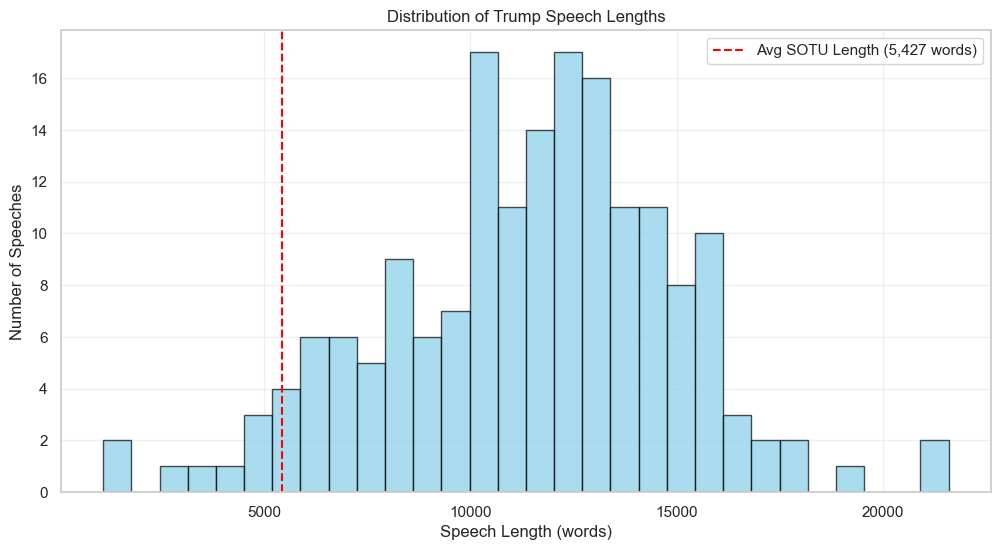

In [36]:
sotu_mean_length = df_sotu['text_length'].mean()

# Plot distribution of speech lengths with SOTU average marked
plt.figure(figsize=(12, 6))
plt.hist(df_speech['text_length'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(x=sotu_mean_length, color='red', linestyle='--', label=f'Avg SOTU Length ({int(sotu_mean_length):,} words)')
plt.xlabel('Speech Length (words)')
plt.ylabel('Number of Speeches')
plt.title('Distribution of Trump Speech Lengths')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [37]:
# Calculate percentage of appearances containing each phrase at least once
phrase_percentages = {}
for phrase in SEARCH_PHRASES.keys():
    all_pct = (df[phrase] >= 1).mean() * 100
    speech_pct = (df_speech[phrase] >= 1).mean() * 100
    post_pct = (df_post[phrase] >= 1).mean() * 100
    phrase_percentages[phrase] = {
        'All Appearances': all_pct,
        'Speeches Only': speech_pct, 
        'Post-Inauguration': post_pct
    }

# Create DataFrame and sort by percentage in all appearances
phrase_df = pd.DataFrame.from_dict(phrase_percentages, orient='index')
phrase_df = phrase_df.sort_values('All Appearances', ascending=False)
phrase_df.index.name = 'Phrase'

# Format table for display
styled_df = phrase_df.style.format({
    'All Appearances': '{:.1f}%'.format,
    'Speeches Only': '{:.1f}%'.format,
    'Post-Inauguration': '{:.1f}%'.format
})

print("Percentage of Appearances Containing Each Phrase:")
display(styled_df)


Percentage of Appearances Containing Each Phrase:


,All Appearances,Speeches Only,Post-Inauguration
Phrase,,,
Biden,71.8%,97.2%,60.1%
War,62.0%,96.6%,58.9%
Russia,58.4%,89.8%,51.3%
Washington,44.9%,89.2%,28.5%
Radical,43.8%,91.5%,24.0%
MAGA,39.3%,88.1%,15.2%
Fake News,39.1%,85.8%,24.3%
Court,37.3%,58.5%,21.7%
Patriot,36.7%,88.1%,19.8%


In [38]:
def create_frequency_comparison(df, df_speech, df_post):
    """Create a comparison table of per-speech frequencies across datasets"""
    results = []
    
    for phrase in SEARCH_PHRASES.keys():
        result = {
            'Phrase': phrase,
            'All Data P(≥1)': (df[phrase] >= 1).mean(),
            'All Speeches P(≥1)': (df_speech[phrase] >= 1).mean(),
            'Post-Inauguration P(≥1)': (df_post[phrase] >= 1).mean(),
            'All Data n': len(df),
            'All Speeches n': len(df_speech),
            'Post-Inauguration n': len(df_post)
        }
        results.append(result)
    
    comparison_df = pd.DataFrame(results)
    
    # Format percentages
    for col in ['All Data P(≥1)', 'All Speeches P(≥1)', 'Post-Inauguration P(≥1)']:
        comparison_df[col] = comparison_df[col].map('{:.1%}'.format)
    
    # Sort by All Data frequency
    comparison_df = comparison_df.sort_values('All Data P(≥1)', ascending=False)
    
    return comparison_df

print("Comparison of Per-Speech Frequencies (P(≥1)):")
comparison_table = create_frequency_comparison(df, df_speech, df_post)
display(comparison_table)

# ... existing code ...

Comparison of Per-Speech Frequencies (P(≥1)):


,Phrase,All Data P(≥1),All Speeches P(≥1),Post-Inauguration P(≥1),All Data n,All Speeches n,Post-Inauguration n
2,Biden,71.8%,97.2%,60.1%,539,176,263
8,War,62.0%,96.6%,58.9%,539,176,263
23,Caucus,6.1%,17.0%,0.4%,539,176,263
18,Russia,58.4%,89.8%,51.3%,539,176,263
28,Slavery,5.0%,11.9%,2.3%,539,176,263
5,Washington,44.9%,89.2%,28.5%,539,176,263
9,Radical,43.8%,91.5%,24.0%,539,176,263
14,Birthday,4.6%,5.7%,3.4%,539,176,263
25,Newscum,4.6%,10.8%,1.5%,539,176,263
16,Autopen,4.6%,1.7%,9.1%,539,176,263


## Individual Phrase Analysis

In [39]:
# Find speeches shorter than 6000 words with 4+ mentions of MAGA
short_maga_speeches = df[
    (df['text_length'] < 10200) & 
    (df['MAGA'] >= 4)
][['file', 'MAGA']]

print(f"\nSpeeches under 10200 words with 4+ mentions of MAGA:")
print(short_maga_speeches.sort_values('MAGA', ascending=False))


Speeches under 10200 words with 4+ mentions of MAGA:
                                                                                     file  \
309             2024-10-30_donald_trump_holds_a_campaign_rally_in_green_bay_wisconsin.txt   
254            2024-04-02_donald_trump_holds_a_political_rally_in_green_bay_wisconsin.txt   
365  2024-05-31_donald_trump_addresses_his_new_york_felony_convictions_at_trump_tower.txt   
368                 2024-10-11_donald_trump_holds_a_campaign_rally_in_aurora_colorado.txt   
364         2024-01-16_donald_trump_holds_a_political_rally_in_atkinson_new_hampshire.txt   
366          2024-10-25_donald_trump_holds_a_campaign_rally_in_traverse_city_michigan.txt   
224         2025-01-20_donald_trump_holds_a_post-inaugural_rally_at_capitol_one_arena.txt   
310       2024-09-21_donald_trump_holds_a_campaign_rally_in_wilmington_north_carolina.txt   
286          2025-06-26_donald_trump_hosts_a_political_event_in_support_of_his_budget.txt   
307            2

In [40]:
df[df['January 6'] > 0][['file', 'text_length', 'January 6', 'category']]

KeyError: 'January 6'

In [19]:
df[df['LA'] > 0][['file', 'text_length', 'LA', 'category']].sort_values('file')

,file,text_length,LA,category
203,2023-09-29_donald_trump_addresses_a_california_gop_lunch_event_in_anaheim.txt,15552,4,speech
233,2023-10-01_donald_trump_holds_a_campaign_event_in_ottumwa_iowa.txt,13209,1,speech
96,2023-10-07_donald_trump_holds_a_campaign_rally_in_waterloo_iowa.txt,10179,1,speech
136,2023-10-11_donald_trump_addresses_his_club_47_fan_club_in_west_palm_beach_florida.txt,17529,1,speech
190,2023-12-17_donald_trump_holds_a_political_rally_in_reno_nevada.txt,10979,1,speech
114,2024-01-05_donald_trump_holds_a_campaign_rally_in_sioux_center_iowa.txt,19189,2,speech
146,2024-01-06_donald_trump_holds_a_campaign_event_in_clinton_iowa.txt,11001,1,speech
97,2024-01-19_donald_trump_holds_a_political_rally_in_concord_new_hampshire.txt,15275,1,speech
232,2024-01-21_donald_trump_holds_a_political_rally_in_rochester_new_hampshire.txt,13102,2,speech
94,2024-01-22_donald_trump_holds_a_political_rally_in_laconia_new_hampshire.txt,11312,1,speech


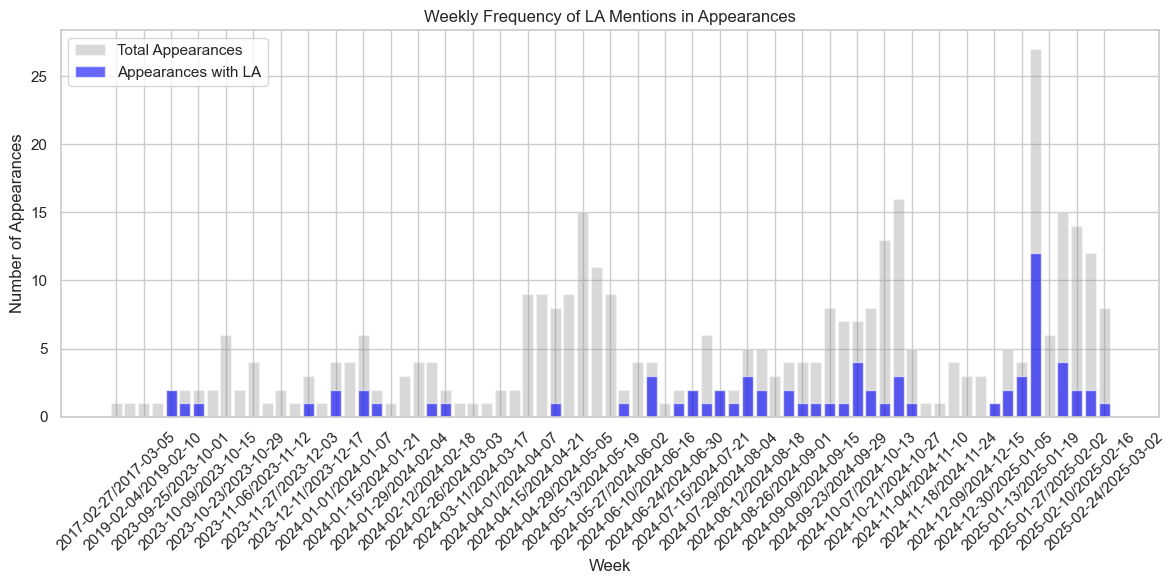

In [20]:
# Convert date strings to datetime 
df['date'] = pd.to_datetime(df['date'])

# Create weekly bins
df['week'] = df['date'].dt.to_period('W')

# Group by week and calculate metrics
weekly_stats = df.groupby('week').agg({
    'file': 'count',  # Total speeches per week
    'LA': lambda x: (x > 0).sum()  # Speeches containing LA per week
}).reset_index()

# Create figure
fig, ax = plt.subplots(figsize=(12, 6))

# Plot bars for speech counts
ax.bar(range(len(weekly_stats)), weekly_stats['file'], alpha=0.3, color='gray', label='Total Appearances')
ax.bar(range(len(weekly_stats)), weekly_stats['LA'], alpha=0.6, color='blue', label='Appearances with LA')

# Customize axes
ax.set_xlabel('Week')
ax.set_ylabel('Number of Appearances')

# Set x-axis ticks to show dates every 2 weeks
tick_indices = range(0, len(weekly_stats), 2)
plt.xticks(tick_indices, [str(weekly_stats['week'].iloc[i]) for i in tick_indices], rotation=45)

# Add legend
ax.legend(loc='upper left')

plt.title('Weekly Frequency of LA Mentions in Appearances')
plt.tight_layout()
plt.show()
